# **ARIMA-Based Time Series Forecasting Simulator**

How It Works

1. Load Data: Reads the sensor data from a CSV file.
2.	Preprocess Data: Converts timestamps to datetime format and resamples to hourly data.
3.	Check Stationarity: Runs the Augmented Dickey-Fuller (ADF) test to check if differencing is needed.
4.	Fit ARIMA Model: Uses (p=5, d=1, q=0) as an example (can be optimized).
5.	Forecast: Predicts the next 24 hours of sensor readings.
6.	Visualization: Plots both historical data and future predictions.

## Correlation of every channels among three different datasets

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon
from pmdarima.arima.utils import ndiffs

In [ ]:
# load data
file_path = "../databases/processed_data/cd230831.csv"
file_path2 = "../databases/processed_data/cd230926.csv"
file_path3 = "../databases/processed_data/cd240111.csv"
df = pd.read_csv(file_path, index_col=0, parse_dates=True)  # parse_dates=True to convert the 'date' column to datetime64[ns]
df1 = pd.read_csv(file_path2, index_col=0, parse_dates=True)  
df2 = pd.read_csv(file_path3, index_col=0, parse_dates=True)  

# calculate the correlation matrix
correlation_matrix = df.corr(method="pearson")
correlation_matrix1 = df1.corr(method="pearson")
correlation_matrix2 = df2.corr(method="pearson")

# create a figure and a set of subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 8)) 

# create the first heatmap
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[0])
axes[0].set_title("Sensor Data Correlation Heatmap for CD230831")

# create the second heatmap
sns.heatmap(correlation_matrix1, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[1])
axes[1].set_title("Sensor Data Correlation Heatmap for CD230926")

# create the third heatmap
sns.heatmap(correlation_matrix2, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[2])
axes[2].set_title("Sensor Data Correlation Heatmap for CD240111")

# adjust the layout
plt.tight_layout()
plt.show()

In [ ]:
def run_arima_forecast(df, sensor, steps_ahead=120, train_split_ratio=0.8, plot_actual_forecast=True, plot_residuals=True):
    """
    Run ARIMA forecasting for a given sensor.

    Parameters:
        df (pd.DataFrame): The input DataFrame containing the sensor data.
        sensor (str): The name of the sensor column to forecast.
        steps_ahead (int): Number of steps to forecast (default: 120 for 1 hour at 30-second intervals).
        train_split_ratio (float): Ratio of training data (default: 0.8).
        plot_actual_forecast (bool): Whether to plot actual vs. forecasted values (default: True).
        plot_residuals (bool): Whether to plot residuals (default: True).

    Returns:
        dict: A dictionary containing forecast results and evaluation metrics.
    """
    print(f"\nProcessing ARIMA for {sensor}")
    
    # Step 1: Load and clean data
    data = df[sensor].dropna()

    # Step 2: Ensure data is stationary
    def check_stationarity(series):
        from statsmodels.tsa.stattools import adfuller
        result = adfuller(series.dropna())
        return result[1] <= 0.05  # Return True if p-value <= 0.05

    def make_stationary(series):
        return series.diff().dropna()

    if not check_stationarity(data):
        data = make_stationary(data)
        print(f"Applied differencing to {sensor} to ensure stationarity.")

    # Step 3: Find the optimal ARIMA parameters
    def find_best_arima_params(series):
        try:
            auto_arima_model = auto_arima(series, seasonal=False, stepwise=True, suppress_warnings=True, trace=True)
            return auto_arima_model.order
        except Exception as e:
            print(f"Auto ARIMA failed: {e}")
            return (1, 0, 1)  # Default to a simple ARIMA(1,0,1) model

    best_order = find_best_arima_params(data)
    print(f"Optimal ARIMA Order for {sensor}: {best_order}")
    
    # Step 4: Train the ARIMA model
    model = ARIMA(data, order=best_order)
    model_fit = model.fit()
    
    # Step 5: Forecast future values
    forecast = model_fit.forecast(steps=steps_ahead)

    # Generate time index for the forecast
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(seconds=30), 
                                   periods=steps_ahead, 
                                   freq='30s')

    # Create DataFrame for forecast results
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)

    # Step 6: Evaluate Model Performance
    train_size = int(len(data) * train_split_ratio)
    train, test = data[:train_size], data[train_size:]
    forecast_test = model_fit.forecast(steps=len(test))

    # Compute MAE and RMSE
    mae = mean_absolute_error(test, forecast_test)
    rmse = np.sqrt(mean_squared_error(test, forecast_test))
    
    # KS test
    ks_stat, ks_p_value = ks_2samp(test, forecast_test)

    # Jensen-Shannon divergence (instead of KL)
    js_divergence = jensenshannon(test + 1e-10, forecast_test + 1e-10)

    # Print evaluation metrics
    print(f"\nEvaluation Metrics for {sensor}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
    print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

    # Step 7: Plot actual vs. forecasted values
    if plot_actual_forecast:
        plt.figure(figsize=(12, 5))
        plt.plot(data.index[-500:], data.values[-500:], label=f"Actual {sensor}", color='blue')
        plt.plot(forecast_df.index, forecast_df["Forecasted Values"], label=f"Forecasted {sensor}", color='red', linestyle='dashed')
        plt.xlabel("Datetime")
        plt.ylabel("Value")
        plt.title(f"1-Hour ARIMA Forecast for {sensor}")
        plt.legend()
        plt.show()

    # Step 8: Plot Residuals
    if plot_residuals:
        residuals = model_fit.resid
        plt.figure(figsize=(10, 4))
        plt.plot(residuals, label="Residuals", color="purple")
        plt.axhline(y=0, linestyle="--", color="black")
        plt.title(f"Residual Plot for {sensor}")
        plt.legend()
        plt.show()

    # Return results
    results = {
        'sensor': sensor,
        'forecast': forecast_df,
        'metrics': {
            'mae': mae,
            'rmse': rmse,
            'ks_stat': ks_stat,
            'ks_p_value': ks_p_value,
            'js_divergence': js_divergence
        }
    }
    return results

# Arima

## Arima for all Channels

### **Step 1: Install Required Libraries**

In [ ]:
# Install dependencies
%pip install statsmodels pandas numpy matplotlib scikit-learn pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 487.8 kB/s eta 0:00:00a 0:00:01


### **Step 2: Import Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm  # Auto ARIMA optimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import ks_2samp, entropy
import logging
from pmdarima import auto_arima

### **Step 3: Import Sensor Data CSV file**

In [3]:
# Replace "sensor_data.csv" with your actual dataset file
df = pd.read_csv("../databases/processed_data/all.csv")

# Convert 'datetime' column to pandas datetime format and set as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [4]:
print(df.columns)

Index(['cooling_channel0', 'cooling_channel1', 'cooling_channel10',
       'cooling_channel11', 'maxigauge_channel1', 'maxigauge_channel2',
       'maxigauge_channel3', 'maxigauge_channel4', 'maxigauge_channel5',
       'maxigauge_channel6', 'temperature_channel1', 'temperature_channel2',
       'temperature_channel5', 'temperature_channel6'],
      dtype='object')


In [5]:
df

,cooling_channel0,cooling_channel1,cooling_channel10,cooling_channel11,maxigauge_channel1,maxigauge_channel2,maxigauge_channel3,maxigauge_channel4,maxigauge_channel5,maxigauge_channel6,temperature_channel1,temperature_channel2,temperature_channel5,temperature_channel6
datetime,,,,,,,,,,,,,,
2023-08-31 00:00:30,15.596670,15.558330,15.542780,15.555560,0.020,0.088700,-1.480000,150.000000,710.0,998.00,293.079000,293.751000,293.731000,0.0
2023-08-31 00:01:00,15.594503,15.558330,15.538204,15.546651,0.020,0.088713,-1.474754,150.000000,710.0,998.00,293.079033,293.751017,293.730633,0.0
2023-08-31 00:01:30,15.592003,15.558330,15.532924,15.536371,0.020,0.088762,-1.455082,150.000000,710.0,998.00,293.080033,293.751517,293.719633,0.0
2023-08-31 00:02:00,15.590465,15.553758,15.537758,15.549443,0.020,0.088800,-1.440000,150.000000,710.0,998.00,293.080951,293.752148,293.709721,0.0
2023-08-31 00:02:30,15.589075,15.548483,15.544148,15.566108,0.020,0.088800,-1.440000,150.000000,710.0,998.00,293.079475,293.756574,293.731361,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-19 23:52:00,15.637736,15.597239,15.547758,15.584887,0.135,0.003416,-3.042097,679.000000,723.0,2.76,267.005050,222.478600,209.079750,0.0
2024-01-19 23:52:30,15.656773,15.617553,15.570407,15.608773,0.135,0.003420,-3.034098,678.918033,723.0,2.76,267.028550,222.510600,209.112250,0.0
2024-01-19 23:53:00,15.665943,15.620053,15.565132,15.603773,0.135,0.003420,-3.058689,678.426230,723.0,2.76,267.048900,222.541850,209.147750,0.0


In [6]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

### **Step 4: Remove outliers for temperature channels**

In [9]:
# # Define physical limits for temperature channels
# temperature_ranges = {
#     "temperature_channel1": (35000, 50000),  # PT1: 35K~50K
#     "temperature_channel2": (3000, 4000),    # PT2: 3K~4K
#     "temperature_channel5": (0, 1000),       # Still: <1K
#     "temperature_channel6": (0, 0.01),       # MXC: <10mK
# }

# # Function to remove outliers based on predefined physical limits
# def remove_temperature_outliers(df):
#     for channel, (lower, upper) in temperature_ranges.items():
#         if channel in df.columns:
#             df[channel] = df[channel].clip(lower=lower, upper=upper)
#     return df

# # Apply outlier removal for temperature channels
# df = remove_temperature_outliers(df)

### **Step 5: Check for Stationarity**

In [7]:
# Function to check stationarity and apply differencing if needed
def check_and_make_stationary(series):
    """
    Check stationarity using ADF test and apply differencing if necessary.
    Returns:
    - transformed_series: Stationary time series (after differencing if required)
    - is_stationary: Boolean (True if stationary, False otherwise)
    """
    series = series.dropna()

    if len(series) < 10:  # Ensure minimum length
        print(f"Skipping {series.name}, not enough data points.")
        return series, True  # Assume stationary to avoid errors

    # Augmented Dickey-Fuller (ADF) test
    result = adfuller(series)
    p_value = result[1]

    if p_value > 0.05:  # If non-stationary, apply differencing
        print(f"{series.name} is NOT stationary (p={p_value:.4f}). Applying differencing...")
        return series.diff().dropna(), False
    else:
        print(f"{series.name} is already stationary (p={p_value:.4f}).")
        return series, True

### **Step 6: Determine Optimal ARIMA Parameters**

In [ ]:
# Function to find optimal ARIMA parameters
def find_best_arima_params(series):
    series = series.dropna()

    if len(series) < 10:  # Ensure enough data points
        raise ValueError(f"Not enough data for ARIMA: {len(series)} points available.")

    if series.nunique() == 1:  # Avoid constant time series
        raise ValueError(f"{series.name} contains only one unique value, ARIMA cannot be trained.")

    try:
        auto_arima_model = auto_arima(series, seasonal=False, stepwise=True,
                                      suppress_warnings=True, trace=True, error_action='ignore')
        return auto_arima_model.order
    except Exception as e:
        print(f"Auto ARIMA failed for {series.name}: {e}")
        return (1, 0, 1)  # Default fallback ARIMA(1,0,1)

### **Step 7: Train ARIMA Model**

In [9]:
forecast_results = {}

In [ ]:
# Iterate over all sensors in the dataset
for sensor in df.columns:
    print(f"\nProcessing ARIMA for {sensor}")
    
    data = df[sensor].dropna()

    # Ensure the data is a valid Pandas Series
    if not isinstance(data, pd.Series):
        data = pd.Series(data)

    if len(data) < 10:  # Skip short series
        print(f"Skipping {sensor}, not enough data points.")
        continue

    if data.nunique() == 1:  # Skip constant data
        print(f"Skipping {sensor}, only one unique value.")
        continue

    # Step 2: Ensure data is stationary
    data, is_stationary = check_and_make_stationary(data)

    # Step 3: Find optimal ARIMA parameters
    best_order = find_best_arima_params(data)
    print(f"Optimal ARIMA Order for {sensor}: {best_order}")

    # Step 4: Train the ARIMA model
    model = ARIMA(data, order=best_order)
    model_fit = model.fit()

    # Step 5: Forecast next 1 hour (60 steps, assuming 30-second intervals)
    steps_ahead = min(60, len(data) // 2)  # Ensure we don't forecast too far for small datasets
    forecast = model_fit.forecast(steps=steps_ahead)

    # Generate time index for the forecast
    forecast_index = pd.date_range(
        start=data.index[-1] + pd.Timedelta(seconds=30), 
        periods=steps_ahead, 
        freq='30s'
    )

    # Create DataFrame for forecast results
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    
    # Store forecast results
    forecast_results[sensor] = forecast_df

    # Step 6: Evaluate Model Performance
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    if len(test) > 0:
        forecast_test = model_fit.forecast(steps=len(test))

        # Calculate MAE and RMSE
        mae = mean_absolute_error(test, forecast_test)
        rmse = np.sqrt(mean_squared_error(test, forecast_test))

        # KS test
        ks_stat, ks_p_value = ks_2samp(test, forecast_test)

        # KL Divergence (requires nonzero values)
        test_nonzero = test + 1e-10
        forecast_nonzero = forecast_test + 1e-10
        kl_divergence = entropy(test_nonzero, forecast_nonzero)

        # Print evaluation metrics
        print(f"\nEvaluation Metrics for {sensor}:")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
        print(f"Kullback-Leibler Divergence: {kl_divergence:.4f}")
        
        # Plot the forecasted values
        plt.figure(figsize=(12, 5))
        plt.plot(data.index[-500:], data.values[-500:], label=f"Actual {sensor}", color='blue')
        plt.plot(forecast_df.index, forecast_df["Forecasted Values"], label=f"Forecasted {sensor}", color='red', linestyle='dashed')
        plt.xlabel("Datetime")
        plt.ylabel("Value")
        plt.title(f"1-Hour ARIMA Forecast for {sensor}")
        plt.legend()
        plt.show()


Processing ARIMA for cooling_channel0
cooling_channel0 is already stationary (p=0.0029).
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-428265.555, Time=61.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-309566.964, Time=3.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-352019.577, Time=4.43 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=10.62 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-309568.964, Time=1.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-420354.968, Time=30.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-430638.813, Time=23.57 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-425348.328, Time=21.08 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-377037.016, Time=3.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-432340.042, Time=30.54 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-399139.101, Time=3.11 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-432020.567, Time=42.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AI

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for cooling_channel0:
Mean Absolute Error (MAE): 12.96
Root Mean Squared Error (RMSE): 13.56
Kolmogorov-Smirnov Statistic: 0.9833, p-value: 0.0000
Kullback-Leibler Divergence: 0.0112

Processing ARIMA for cooling_channel1
cooling_channel1 is already stationary (p=0.0000).
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-634255.608, Time=38.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-518476.369, Time=3.29 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-555831.791, Time=3.94 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-622461.701, Time=10.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-518478.369, Time=1.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-623539.399, Time=29.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-632798.530, Time=28.43 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-634244.058, Time=36.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-626880.306, Time=41.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   :

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r


Evaluation Metrics for cooling_channel1:
Mean Absolute Error (MAE): 2.51
Root Mean Squared Error (RMSE): 2.89
Kolmogorov-Smirnov Statistic: 0.9886, p-value: 0.0000
Kullback-Leibler Divergence: 0.0029

Processing ARIMA for cooling_channel10
cooling_channel10 is already stationary (p=0.0015).
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-443078.909, Time=38.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-321886.431, Time=4.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-371698.270, Time=4.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-433612.586, Time=8.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-321888.431, Time=1.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-446855.306, Time=32.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-446437.134, Time=18.33 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-443076.604, Time=16.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-446704.280, Time=29.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : 

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for cooling_channel10:
Mean Absolute Error (MAE): 11.90
Root Mean Squared Error (RMSE): 12.44
Kolmogorov-Smirnov Statistic: 0.9911, p-value: 0.0000
Kullback-Leibler Divergence: 0.0097

Processing ARIMA for cooling_channel11
cooling_channel11 is already stationary (p=0.0000).
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-656070.495, Time=39.70 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-543107.859, Time=4.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-585649.202, Time=3.51 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-648638.720, Time=14.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-543109.859, Time=1.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-651384.347, Time=25.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-658048.661, Time=27.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-654485.523, Time=18.89 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-608639.197, Time=4.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept  

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for cooling_channel11:
Mean Absolute Error (MAE): 2.72
Root Mean Squared Error (RMSE): 3.18
Kolmogorov-Smirnov Statistic: 0.9904, p-value: 0.0000
Kullback-Leibler Divergence: 0.0037

Processing ARIMA for maxigauge_channel1
maxigauge_channel1 is already stationary (p=0.0000).
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=526654.449, Time=2.79 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1129099.895, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.43 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=2.25 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=532576.032, Time=3.69 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=529569.535, Time=3.85 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=526325.253, Time=10.69 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=526332.113, Time=7.73 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=526129.341, Time=11.81 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=526331.523, Time=1

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for maxigauge_channel1:
Mean Absolute Error (MAE): 0.72
Root Mean Squared Error (RMSE): 0.72
Kolmogorov-Smirnov Statistic: 1.0000, p-value: 0.0000
Kullback-Leibler Divergence: 2.5026

Processing ARIMA for maxigauge_channel2
maxigauge_channel2 is already stationary (p=0.0000).
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=608622.628, Time=14.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=729073.598, Time=0.81 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=702583.318, Time=0.89 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=630401.802, Time=4.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=729071.598, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=622317.006, Time=9.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=612622.360, Time=7.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=605356.860, Time=16.94 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=612344.170, Time=11.02 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=592

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for maxigauge_channel2:
Mean Absolute Error (MAE): 2.25
Root Mean Squared Error (RMSE): 25.82
Kolmogorov-Smirnov Statistic: 0.8775, p-value: 0.0000
Kullback-Leibler Divergence: 4.6049

Processing ARIMA for maxigauge_channel3
maxigauge_channel3 is already stationary (p=0.0000).
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=594446.098, Time=29.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=727439.824, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=638879.747, Time=0.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=613856.060, Time=3.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=727437.824, Time=0.36 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=594517.501, Time=6.73 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=594491.925, Time=6.12 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=594481.887, Time=9.13 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=594519.953, Time=10.44 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=595

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for maxigauge_channel3:
Mean Absolute Error (MAE): 462.07
Root Mean Squared Error (RMSE): 570.45
Kolmogorov-Smirnov Statistic: 0.7006, p-value: 0.0000
Kullback-Leibler Divergence: inf

Processing ARIMA for maxigauge_channel4
maxigauge_channel4 is already stationary (p=0.0005).
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=737033.179, Time=18.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=835372.904, Time=0.78 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=806715.562, Time=1.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=748639.410, Time=3.95 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=835370.944, Time=0.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=744800.043, Time=9.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=736770.261, Time=7.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=746564.835, Time=4.76 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=766464.460, Time=2.38 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7366

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for maxigauge_channel4:
Mean Absolute Error (MAE): 132.80
Root Mean Squared Error (RMSE): 217.53
Kolmogorov-Smirnov Statistic: 0.8840, p-value: 0.0000
Kullback-Leibler Divergence: 0.0601

Processing ARIMA for maxigauge_channel5
maxigauge_channel5 is NOT stationary (p=0.0660). Applying differencing...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=608150.325, Time=5.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=728721.112, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=702242.173, Time=0.45 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=628953.035, Time=1.49 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=625053.043, Time=3.49 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=610316.047, Time=2.77 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=607526.938, Time=7.05 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=610199.361, Time=3.85 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=593061.784, Time=6.93 sec
 ARIMA(4,0,1)(0,0,0)[0]

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r


Evaluation Metrics for maxigauge_channel5:
Mean Absolute Error (MAE): 0.71
Root Mean Squared Error (RMSE): 8.72
Kolmogorov-Smirnov Statistic: 0.7324, p-value: 0.0000
Kullback-Leibler Divergence: inf

Processing ARIMA for maxigauge_channel6
maxigauge_channel6 is already stationary (p=0.0000).
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=720987.820, Time=21.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=745297.988, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=725536.541, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=722006.498, Time=3.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=745296.282, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=721639.111, Time=21.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=721421.414, Time=5.53 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=720946.132, Time=30.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=721411.978, Time=25.75 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=72093

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for maxigauge_channel6:
Mean Absolute Error (MAE): 1.28
Root Mean Squared Error (RMSE): 1.54
Kolmogorov-Smirnov Statistic: 0.8958, p-value: 0.0000
Kullback-Leibler Divergence: 0.1907

Processing ARIMA for temperature_channel1
temperature_channel1 is already stationary (p=0.0233).
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-464277.197, Time=35.35 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-408648.003, Time=5.80 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-431381.519, Time=5.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-462712.798, Time=15.50 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-408650.009, Time=1.16 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-463185.723, Time=16.78 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-464393.552, Time=23.74 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-464264.460, Time=18.70 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-441136.483, Time=5.02 sec
 ARIMA(3,2,1)(0,0,0)[0] interc

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for temperature_channel1:
Mean Absolute Error (MAE): 384.69
Root Mean Squared Error (RMSE): 397.01
Kolmogorov-Smirnov Statistic: 1.0000, p-value: 0.0000
Kullback-Leibler Divergence: 0.2632

Processing ARIMA for temperature_channel2
temperature_channel2 is NOT stationary (p=0.1078). Applying differencing...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-264876.748, Time=39.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189495.440, Time=3.83 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-222310.403, Time=3.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-264794.618, Time=13.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189497.440, Time=1.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-264798.890, Time=30.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-264883.364, Time=26.76 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-264880.124, Time=19.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-235524.461, Time=2.51 sec
 AR

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r


Evaluation Metrics for temperature_channel2:
Mean Absolute Error (MAE): 0.05
Root Mean Squared Error (RMSE): 0.07
Kolmogorov-Smirnov Statistic: 0.9016, p-value: 0.0000
Kullback-Leibler Divergence: inf

Processing ARIMA for temperature_channel5
temperature_channel5 is NOT stationary (p=0.2283). Applying differencing...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-219506.925, Time=59.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-143848.505, Time=2.76 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-176780.890, Time=2.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-219277.217, Time=287.86 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-143850.505, Time=1.69 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-219292.448, Time=16.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-219576.327, Time=29.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-219505.755, Time=38.64 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-190096.797, Time=2.61 sec
 ARIMA(3,

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for temperature_channel5:
Mean Absolute Error (MAE): 0.06
Root Mean Squared Error (RMSE): 0.07
Kolmogorov-Smirnov Statistic: 0.9098, p-value: 0.0000
Kullback-Leibler Divergence: inf

Processing ARIMA for temperature_channel6
temperature_channel6 is already stationary (p=0.0000).
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=78548.872, Time=19.22 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=207420.928, Time=2.43 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=181944.221, Time=1.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=105793.627, Time=7.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=207418.928, Time=1.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=105447.445, Time=18.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=81457.019, Time=8.75 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=81187.441, Time=16.52 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=77778.390, Time=29.94 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=782

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starti


Evaluation Metrics for temperature_channel6:
Mean Absolute Error (MAE): 6.68
Root Mean Squared Error (RMSE): 21.04
Kolmogorov-Smirnov Statistic: 0.8455, p-value: 0.0000
Kullback-Leibler Divergence: 2.1085


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


### Control d value no more than 2

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon
from pmdarima.arima.utils import ndiffs

In [27]:
# Replace "sensor_data.csv" with your actual dataset file
df = pd.read_csv("../databases/processed_data/all.csv")

# Convert 'datetime' column to pandas datetime format and set as index
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [ ]:
# Function to find best arima parameters with d constrained to ≤2, and p, q ≤ 3
def find_best_arima_params_2(series):
    """Finds the best ARIMA parameters with d constrained to ≤2."""
    series = series.dropna()

    if len(series) < 10:
        raise ValueError(f"Not enough data for ARIMA: {len(series)} points available.")
    if series.nunique() == 1:
        raise ValueError(f"{series.name} contains only one unique value, ARIMA cannot be trained.")
    try:
        auto_arima_model = auto_arima(series, seasonal=False, max_d=2, max_p=3, max_q=3,
                                      suppress_warnings=True, stepwise=True, trace=True)
        return auto_arima_model.order
    except Exception as e:
        print(f"Auto ARIMA failed for {series.name}: {e}")
        return (1, 0, 1)  # Default fallback ARIMA(1,0,1)

In [32]:
def check_and_make_stationary_2(series):
    """Checks and makes the series stationary if needed."""
    from statsmodels.tsa.stattools import adfuller
    p_value = adfuller(series)[1]
    is_stationary = p_value < 0.05
    if not is_stationary:
        series = series.diff().dropna()
    return series, is_stationary


Processing ARIMA for cooling_channel0
cooling_channel0 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-428265.555, Time=44.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-309566.964, Time=3.47 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-352019.577, Time=4.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=10.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-309568.964, Time=1.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-420354.968, Time=35.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-430638.813, Time=26.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-425348.328, Time=23.84 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-377037.016, Time=3.67 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-432340.042, Time=34.47 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-399139.101, Time=3.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-432544.194, Time=39.95 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-432578.229, Ti

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for cooling_channel0:
MAE: 12.96, RMSE: 13.56
KS Stat: 0.9834, p-value: 0.0000
KL Divergence: 0.0112


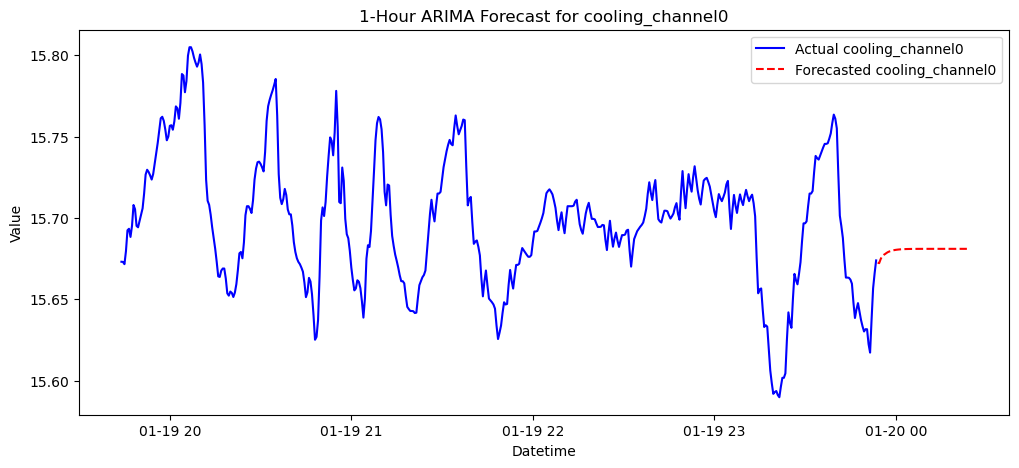


Processing ARIMA for cooling_channel1
cooling_channel1 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-634255.608, Time=43.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-518476.369, Time=4.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-555831.791, Time=5.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-622461.701, Time=15.91 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-518478.369, Time=1.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-623539.399, Time=28.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-632798.530, Time=27.52 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-634244.058, Time=35.53 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-626880.306, Time=39.99 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-627231.172, Time=21.55 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-630505.334, Time=43.53 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-633221.816, Time=31.13 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-6318

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r


Evaluation Metrics for cooling_channel1:
MAE: 2.51, RMSE: 2.89
KS Stat: 0.9886, p-value: 0.0000
KL Divergence: 0.0029


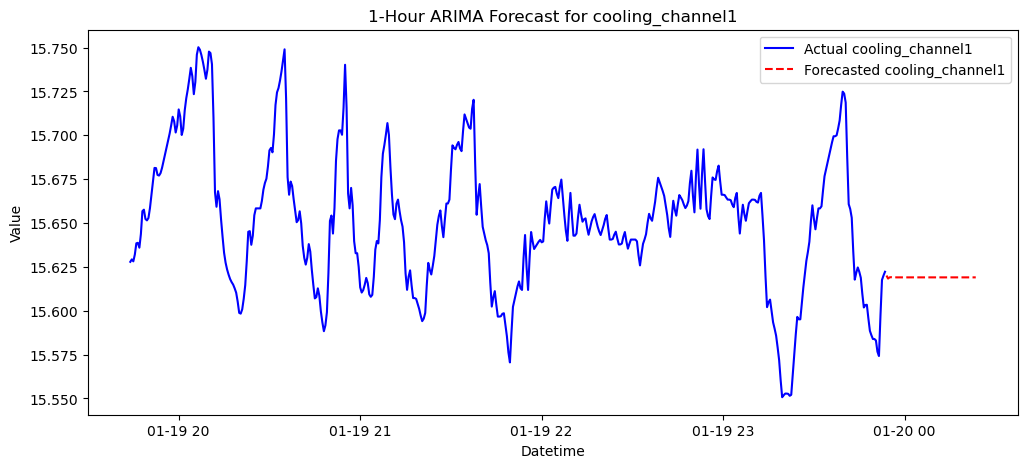


Processing ARIMA for cooling_channel10
cooling_channel10 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-443078.909, Time=44.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-321886.431, Time=4.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-371698.270, Time=4.65 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-433612.586, Time=8.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-321888.431, Time=1.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-446855.306, Time=34.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-446437.134, Time=18.73 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-443076.604, Time=15.65 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-446704.280, Time=29.99 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-446968.432, Time=30.44 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-446970.432, Time=7.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-446439.135, Time=6.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-44699

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for cooling_channel10:
MAE: 11.90, RMSE: 12.44
KS Stat: 0.9911, p-value: 0.0000
KL Divergence: 0.0097


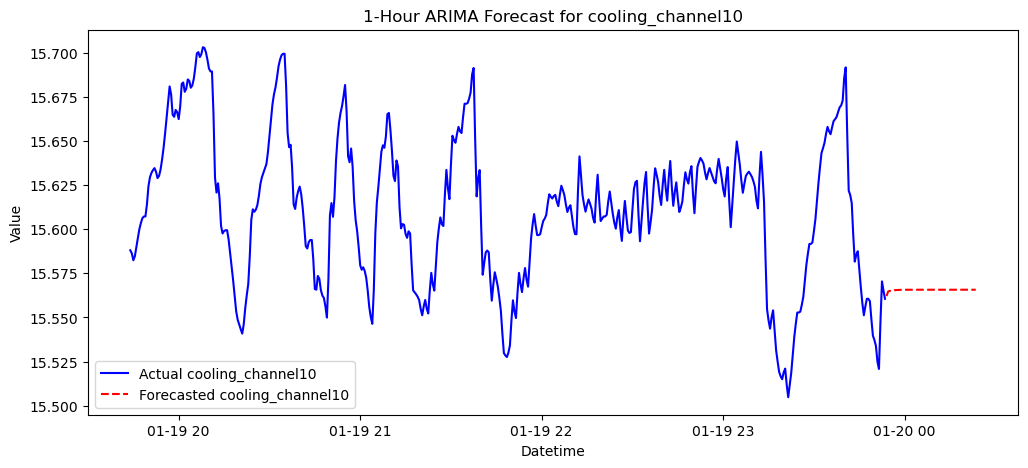


Processing ARIMA for cooling_channel11
cooling_channel11 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-656070.495, Time=39.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-543107.859, Time=4.86 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-585649.202, Time=4.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-648638.720, Time=18.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-543109.859, Time=1.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-651384.347, Time=25.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-658048.661, Time=25.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-654485.523, Time=17.98 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-608639.197, Time=4.39 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-658585.998, Time=32.56 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-623943.574, Time=5.58 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-652311.389, Time=49.32 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-6593

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for cooling_channel11:
MAE: 2.73, RMSE: 3.19
KS Stat: 0.9924, p-value: 0.0000
KL Divergence: 0.0037


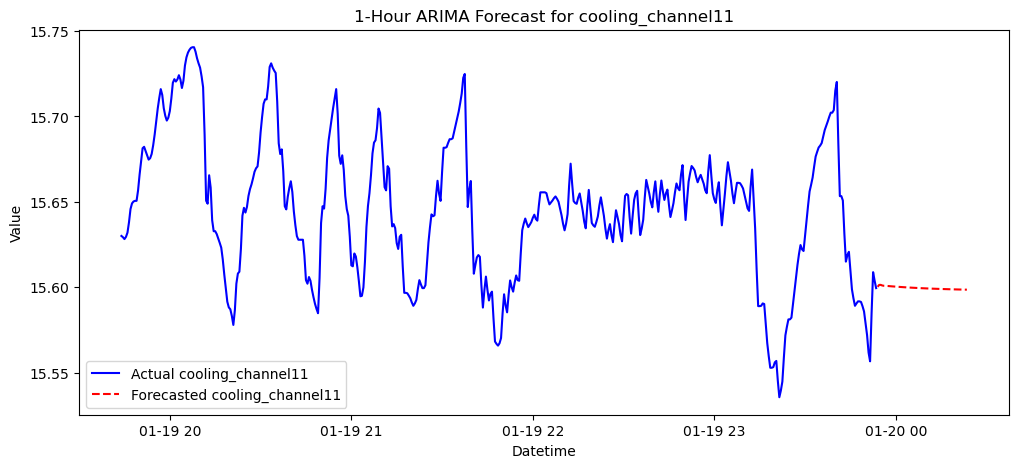


Processing ARIMA for maxigauge_channel1
maxigauge_channel1 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=526654.449, Time=2.80 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1129099.895, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=2.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=532576.032, Time=3.47 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=529569.535, Time=3.78 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=526325.253, Time=10.60 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=526332.113, Time=7.26 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=526655.079, Time=8.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=526542.045, Time=7.03 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=526325.549, Time=29.18 sec

Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 75.105 seconds
Optimal ARIMA Order for maxigauge_channel1: (3, 0, 2)


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r


Evaluation Metrics for maxigauge_channel1:
MAE: 0.72, RMSE: 0.72
KS Stat: 1.0000, p-value: 0.0000
KL Divergence: 2.5026


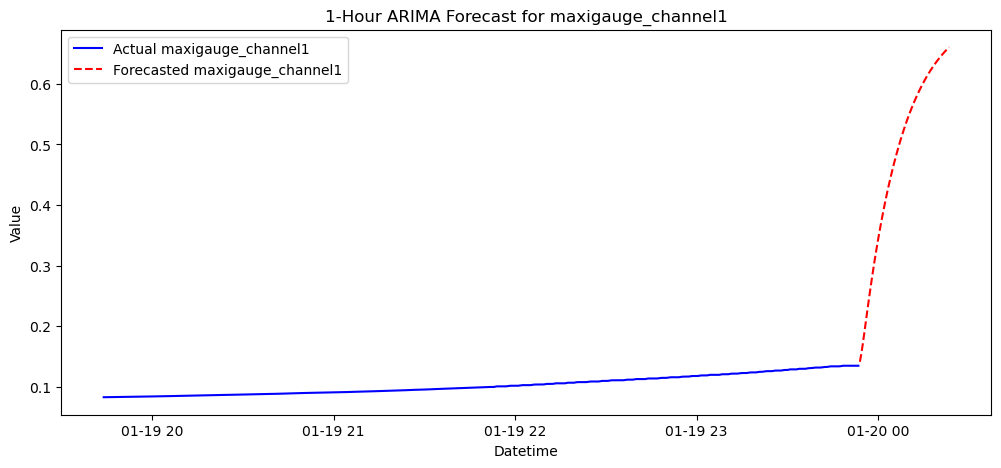


Processing ARIMA for maxigauge_channel2
maxigauge_channel2 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=608622.628, Time=14.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=729073.598, Time=0.93 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=702583.318, Time=1.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=630401.802, Time=5.90 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=729071.598, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=622317.006, Time=9.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=612622.360, Time=6.56 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=605356.860, Time=15.83 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=612344.170, Time=10.84 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=588703.207, Time=31.24 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=588754.345, Time=36.81 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=588701.207, Time=12.46 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=588752.345, Time

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Evaluation Metrics for maxigauge_channel2:
MAE: 2.25, RMSE: 25.82
KS Stat: 0.8775, p-value: 0.0000
KL Divergence: 4.6049


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


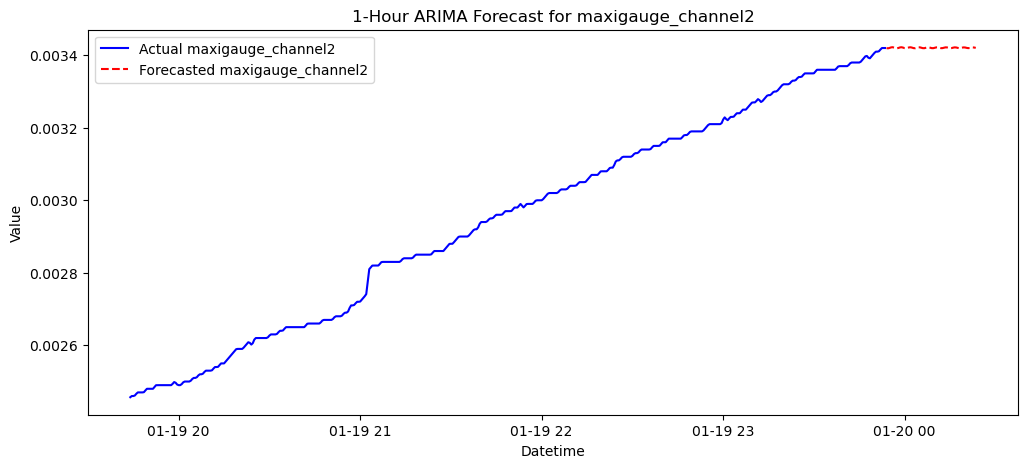


Processing ARIMA for maxigauge_channel3
maxigauge_channel3 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=594446.098, Time=33.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=727439.824, Time=0.77 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=638879.747, Time=0.96 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=613856.060, Time=4.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=727437.824, Time=0.43 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=594517.501, Time=7.03 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=594491.925, Time=6.22 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=594481.887, Time=9.29 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=594519.953, Time=10.46 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=595213.299, Time=5.45 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=594512.347, Time=11.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=594488.981, Time=11.73 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=594330.084, Time=5

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for maxigauge_channel3:
MAE: 462.07, RMSE: 570.45
KS Stat: 0.7006, p-value: 0.0000
KL Divergence: inf


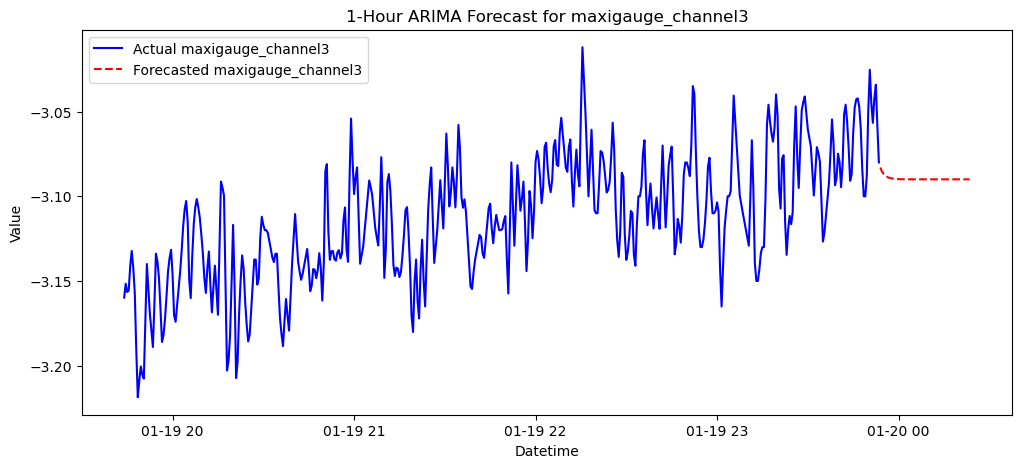


Processing ARIMA for maxigauge_channel4
maxigauge_channel4 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=737033.179, Time=19.49 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=835372.904, Time=0.92 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=806715.562, Time=1.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=748639.410, Time=2.70 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=835370.944, Time=0.32 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=744800.043, Time=9.14 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=736770.261, Time=7.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=746564.835, Time=4.91 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=766464.460, Time=2.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=736639.146, Time=9.79 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=761637.890, Time=2.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=733830.577, Time=15.94 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=732242.302, Time=18.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r


Evaluation Metrics for maxigauge_channel4:
MAE: 132.76, RMSE: 217.51
KS Stat: 0.8840, p-value: 0.0000
KL Divergence: 0.0601


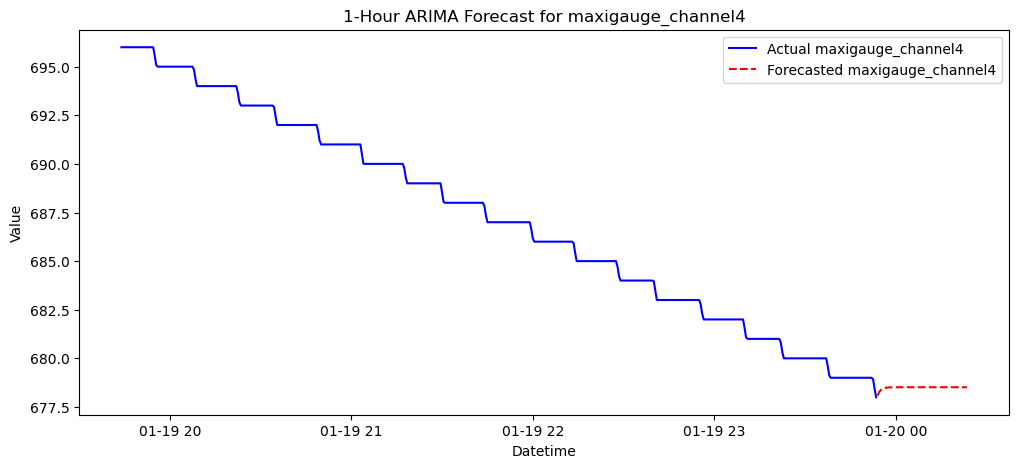


Processing ARIMA for maxigauge_channel5
maxigauge_channel5 Stationary: False
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=608150.325, Time=4.76 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=728721.112, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=702242.173, Time=0.44 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=628953.035, Time=1.43 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=625053.043, Time=3.42 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=610316.047, Time=2.69 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=607526.938, Time=6.68 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=610199.361, Time=3.76 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=599709.625, Time=11.31 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=599719.622, Time=9.67 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=599711.625, Time=26.99 sec

Best model:  ARIMA(3,0,3)(0,0,0)[0]          
Total fit time: 71.426 seconds
Optimal ARIMA Order for maxigauge_channel5: (3, 0, 

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starti


Evaluation Metrics for maxigauge_channel5:
MAE: 0.71, RMSE: 8.72
KS Stat: 0.7296, p-value: 0.0000
KL Divergence: inf


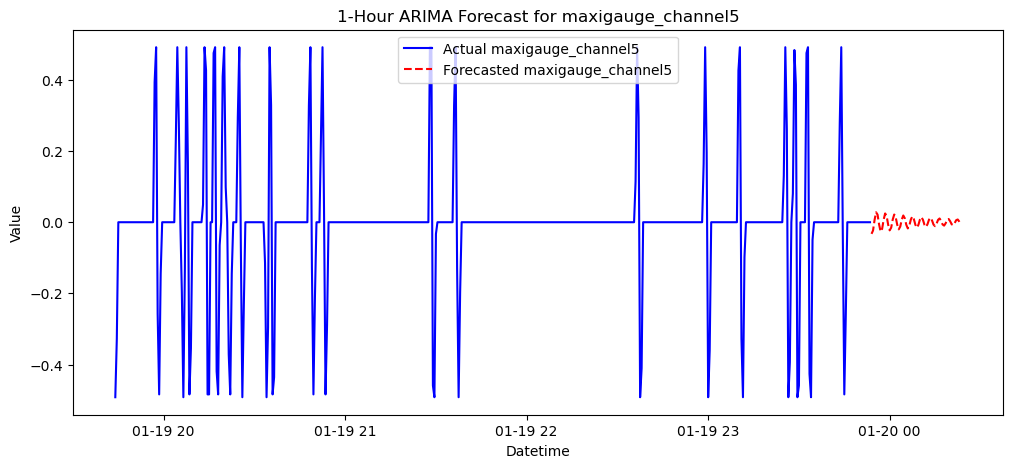


Processing ARIMA for maxigauge_channel6
maxigauge_channel6 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=720987.820, Time=20.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=745297.988, Time=0.88 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=725536.541, Time=1.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=722006.498, Time=4.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=745296.282, Time=0.42 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=721639.111, Time=28.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=721421.414, Time=7.54 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=720946.132, Time=39.68 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=721411.978, Time=34.20 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=720931.736, Time=53.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=720930.409, Time=32.53 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=720941.634, Time=13.33 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=720928.735, Tim

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r


Evaluation Metrics for maxigauge_channel6:
MAE: 1.28, RMSE: 1.54
KS Stat: 0.8958, p-value: 0.0000
KL Divergence: 0.1907


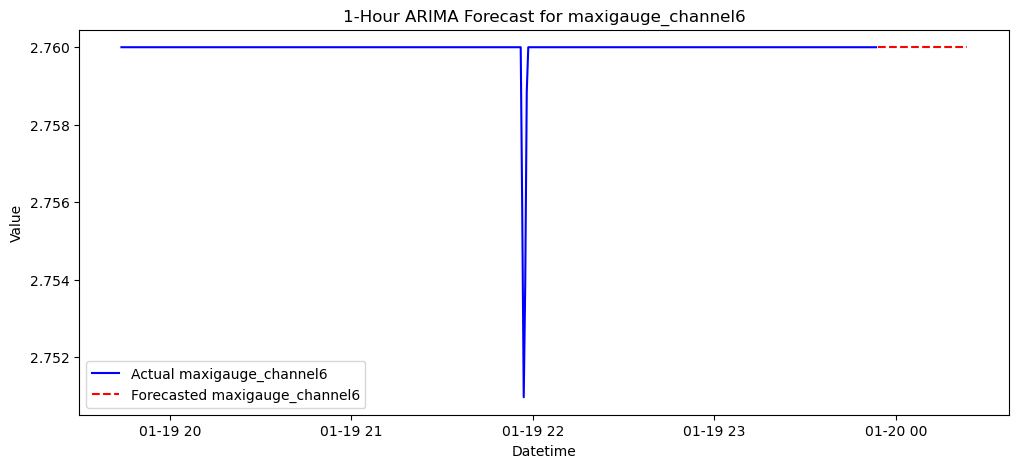


Processing ARIMA for temperature_channel1
temperature_channel1 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-464277.197, Time=34.24 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-408648.003, Time=4.55 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-431381.519, Time=3.89 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-462712.798, Time=12.36 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-408650.009, Time=1.11 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-463185.723, Time=16.98 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-464393.552, Time=24.81 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-464264.460, Time=19.35 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-441136.483, Time=5.38 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-464602.647, Time=38.42 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-446965.561, Time=4.74 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=-464480.642, Time=37.26 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for temperature_channel1:
MAE: 386.10, RMSE: 398.54
KS Stat: 1.0000, p-value: 0.0000
KL Divergence: 0.2632


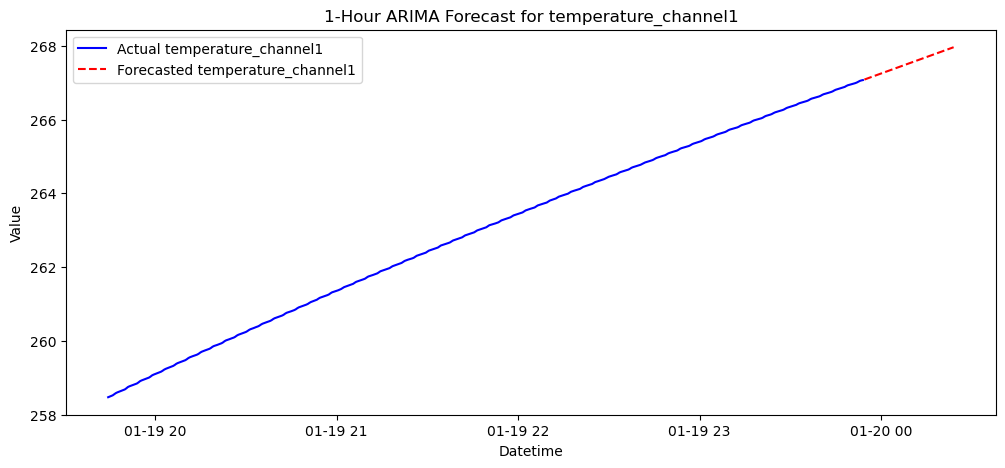


Processing ARIMA for temperature_channel2
temperature_channel2 Stationary: False
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-264876.748, Time=47.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-189495.440, Time=3.77 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-222310.403, Time=2.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-264794.618, Time=12.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-189497.440, Time=1.27 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-264798.890, Time=32.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-264883.364, Time=27.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-264880.124, Time=19.85 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-235524.461, Time=2.66 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-264879.648, Time=33.88 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-242760.991, Time=3.17 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-264878.788, Time=38.75 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AI

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r


Evaluation Metrics for temperature_channel2:
MAE: 0.05, RMSE: 0.07
KS Stat: 0.9016, p-value: 0.0000
KL Divergence: inf


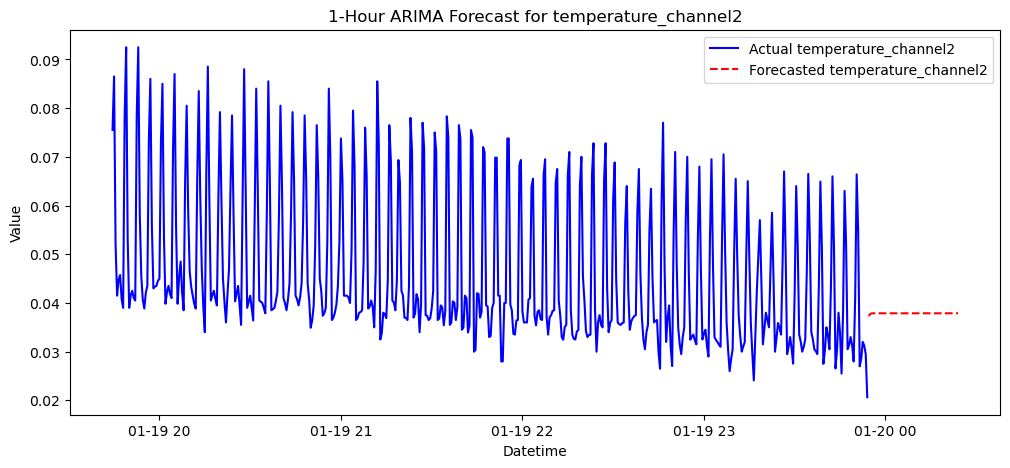


Processing ARIMA for temperature_channel5
temperature_channel5 Stationary: False
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-219506.925, Time=66.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-143848.505, Time=4.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-176780.890, Time=3.94 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-219277.217, Time=23.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-143850.505, Time=1.54 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-219292.448, Time=18.82 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-219576.327, Time=32.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-219505.755, Time=20.27 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-190096.797, Time=2.79 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-219613.019, Time=39.20 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-197342.830, Time=3.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-219149.961, Time=38.07 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AI

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for temperature_channel5:
MAE: 0.06, RMSE: 0.07
KS Stat: 0.9098, p-value: 0.0000
KL Divergence: inf


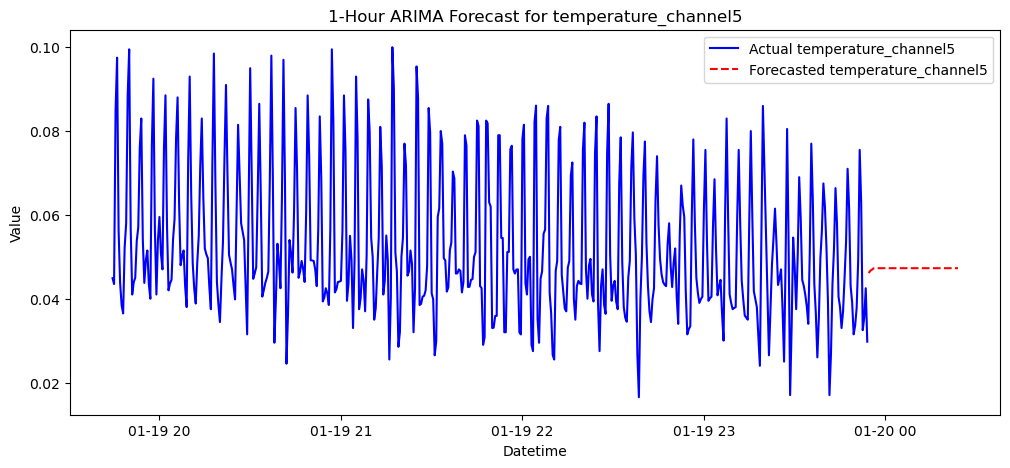


Processing ARIMA for temperature_channel6
temperature_channel6 Stationary: True
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=78548.872, Time=19.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=207420.928, Time=3.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=181944.221, Time=1.98 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=105793.627, Time=8.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=207418.928, Time=1.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=105447.445, Time=22.55 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=81457.019, Time=8.55 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=81187.441, Time=15.62 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=77778.390, Time=30.00 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=78297.431, Time=23.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=77565.489, Time=42.66 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=77563.488, Time=17.13 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=77776.390, Time=14

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Evaluation Metrics for temperature_channel6:
MAE: 6.68, RMSE: 21.04
KS Stat: 1.0000, p-value: 0.0000
KL Divergence: 2.1085


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


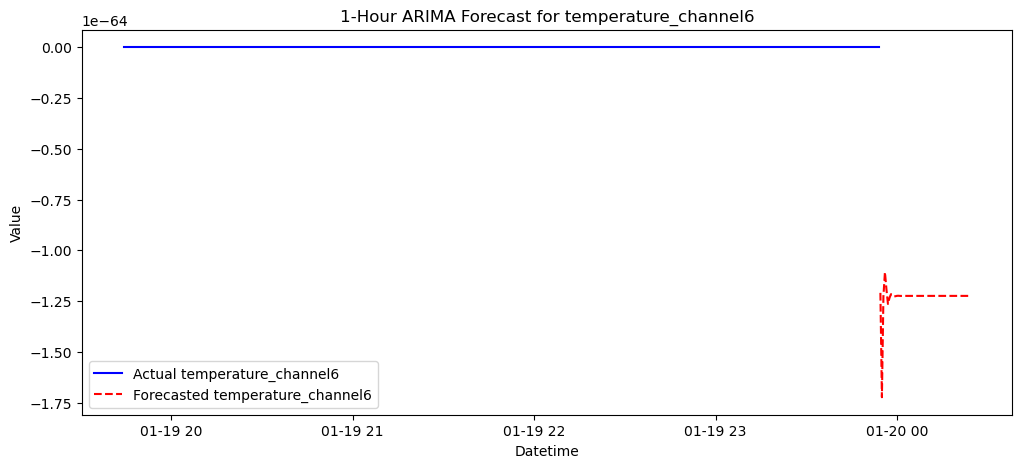

In [33]:
# Main loop for ARIMA modeling
forecast_results = {}

for sensor in df.columns:
    print(f"\nProcessing ARIMA for {sensor}")
    data = df[sensor].dropna()
    
    if not isinstance(data, pd.Series):
        data = pd.Series(data)
    if len(data) < 10:
        print(f"Skipping {sensor}, not enough data points.")
        continue
    if data.nunique() == 1:
        print(f"Skipping {sensor}, only one unique value.")
        continue

    # Ensure stationarity
    data, is_stationary = check_and_make_stationary_2(data)
    print(f"{sensor} Stationary: {is_stationary}")

    # Find ARIMA order
    try:
        best_order = find_best_arima_params_2(data)
        print(f"Optimal ARIMA Order for {sensor}: {best_order}")
    except Exception as e:
        print(f"Skipping {sensor} due to ARIMA failure: {e}")
        continue
    
    # Train ARIMA model
    try:
        model = ARIMA(data, order=best_order)
        model_fit = model.fit()
    except Exception as e:
        print(f"Failed to train ARIMA for {sensor}: {e}")
        continue

    # Forecasting next 1 hour (assuming 30-sec intervals)
    steps_ahead = min(60, len(data) // 2)
    forecast = model_fit.forecast(steps=steps_ahead)
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(seconds=30), 
                                   periods=steps_ahead, freq='30s')
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    forecast_results[sensor] = forecast_df

    # Model evaluation
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    
    if len(test) > 0:
        forecast_test = model_fit.forecast(steps=len(test))
        mae = mean_absolute_error(test, forecast_test)
        rmse = np.sqrt(mean_squared_error(test, forecast_test))
        ks_stat, ks_p_value = ks_2samp(test, forecast_test)
        kl_divergence = entropy(test + 1e-10, forecast_test + 1e-10)

        # Print evaluation
        print(f"\nEvaluation Metrics for {sensor}:")
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        print(f"KS Stat: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
        print(f"KL Divergence: {kl_divergence:.4f}")

        # Plot results
        plt.figure(figsize=(12, 5))
        plt.plot(data.index[-500:], data.values[-500:], label=f"Actual {sensor}", color='blue')
        plt.plot(forecast_df.index, forecast_df["Forecasted Values"], label=f"Forecasted {sensor}",
                 color='red', linestyle='dashed')
        plt.xlabel("Datetime")
        plt.ylabel("Value")
        plt.title(f"1-Hour ARIMA Forecast for {sensor}")
        plt.legend()
        plt.show()

In [34]:
# Function to find best arima parameters with d constrained to ≤2, and p, q ≤ 2
def find_best_arima_params_3(series):
    """Finds the best ARIMA parameters with d constrained to ≤2."""
    series = series.dropna()

    if len(series) < 10:
        raise ValueError(f"Not enough data for ARIMA: {len(series)} points available.")
    if series.nunique() == 1:
        raise ValueError(f"{series.name} contains only one unique value, ARIMA cannot be trained.")
    try:
        auto_arima_model = auto_arima(series, seasonal=False, max_d=2, max_p=2, max_q=2,
                                      suppress_warnings=True, stepwise=True, trace=True)
        return auto_arima_model.order
    except Exception as e:
        print(f"Auto ARIMA failed for {series.name}: {e}")
        return (1, 0, 1)  # Default fallback ARIMA(1,0,1)

In [ ]:
# Main loop for ARIMA modeling
forecast_results = {}

for sensor in df.columns:
    print(f"\nProcessing ARIMA for {sensor}")
    data = df[sensor].dropna()
    
    if not isinstance(data, pd.Series):
        data = pd.Series(data)
    if len(data) < 10:
        print(f"Skipping {sensor}, not enough data points.")
        continue
    if data.nunique() == 1:
        print(f"Skipping {sensor}, only one unique value.")
        continue

    # Ensure stationarity
    data, is_stationary = check_and_make_stationary_2(data)
    print(f"{sensor} Stationary: {is_stationary}")

    # Find ARIMA order
    try:
        best_order = find_best_arima_params_2(data)
        print(f"Optimal ARIMA Order for {sensor}: {best_order}")
    except Exception as e:
        print(f"Skipping {sensor} due to ARIMA failure: {e}")
        continue
    
    # Train ARIMA model
    try:
        model = ARIMA(data, order=best_order)
        model_fit = model.fit()
    except Exception as e:
        print(f"Failed to train ARIMA for {sensor}: {e}")
        continue

    # Forecasting next 1 hour (assuming 30-sec intervals)
    steps_ahead = min(60, len(data) // 2)
    forecast = model_fit.forecast(steps=steps_ahead)
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(seconds=30), 
                                   periods=steps_ahead, freq='30s')
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    forecast_results[sensor] = forecast_df

    # Model evaluation
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    
    if len(test) > 0:
        forecast_test = model_fit.forecast(steps=len(test))
        mae = mean_absolute_error(test, forecast_test)
        rmse = np.sqrt(mean_squared_error(test, forecast_test))
        ks_stat, ks_p_value = ks_2samp(test, forecast_test)
        kl_divergence = entropy(test + 1e-10, forecast_test + 1e-10)

        # Print evaluation
        print(f"\nEvaluation Metrics for {sensor}:")
        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")
        print(f"KS Stat: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
        print(f"KL Divergence: {kl_divergence:.4f}")

        # Plot results
        plt.figure(figsize=(12, 5))
        plt.plot(data.index[-500:], data.values[-500:], label=f"Actual {sensor}", color='blue')
        plt.plot(forecast_df.index, forecast_df["Forecasted Values"], label=f"Forecasted {sensor}",
                 color='red', linestyle='dashed')
        plt.xlabel("Datetime")
        plt.ylabel("Value")
        plt.title(f"1-Hour ARIMA Forecast for {sensor}")
        plt.legend()
        plt.show()

### Step 8: Display forecast results

In [16]:
# Display forecast results
from IPython.display import display
forecast_summary = {sensor: forecast_results[sensor].head(10) for sensor in forecast_results}  
display(forecast_summary)

{'cooling_channel0':                      Forecasted Values
 2024-01-19 23:54:00          15.672250
 2024-01-19 23:54:30          15.671328
 2024-01-19 23:55:00          15.673100
 2024-01-19 23:55:30          15.674586
 2024-01-19 23:56:00          15.675184
 2024-01-19 23:56:30          15.675730
 2024-01-19 23:57:00          15.676415
 2024-01-19 23:57:30          15.677018
 2024-01-19 23:58:00          15.677494
 2024-01-19 23:58:30          15.677916,
 'cooling_channel1':                      Forecasted Values
 2024-01-19 23:54:00          15.620054
 2024-01-19 23:54:30          15.618326
 2024-01-19 23:55:00          15.619021
 2024-01-19 23:55:30          15.619115
 2024-01-19 23:56:00          15.618994
 2024-01-19 23:56:30          15.619007
 2024-01-19 23:57:00          15.619022
 2024-01-19 23:57:30          15.619017
 2024-01-19 23:58:00          15.619016
 2024-01-19 23:58:30          15.619017,
 'cooling_channel10':                      Forecasted Values
 2024-01-19 23:54

## Selected Channels with residual graph

In [17]:
from scipy.stats import ks_2samp, entropy
from pmdarima import auto_arima
from scipy.spatial.distance import jensenshannon

In [38]:
# Select relevant sensor channels for ARIMA modeling
selected_channels = ["maxigauge_channel1", "maxigauge_channel2", "maxigauge_channel6"]

In [40]:
# Function to check and make data stationary
def check_stationarity(data):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(data)
    print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")
    
    if result[1] > 0.05:
        print("Data is NOT stationary, applying first-order differencing...")
        return data.diff().dropna()
    else:
        return data

# Function to find optimal ARIMA order
def find_best_arima_params(data):
    model = auto_arima(data, seasonal=False, trace=True, stepwise=True)
    return model.order


Processing ARIMA for maxigauge_channel1
ADF Statistic: -32.04073745096327, p-value: 0.0
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=526654.449, Time=2.89 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1129099.895, Time=0.27 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.42 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=2.26 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=532576.032, Time=3.49 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=529569.535, Time=3.83 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=526325.253, Time=11.17 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=526332.113, Time=7.38 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=526129.341, Time=11.46 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=526331.523, Time=12.69 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=525889.797, Time=15.22 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=525875.989, Time=14.32 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=540875.935, Time=1

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for maxigauge_channel1:
Mean Absolute Error (MAE): 0.7185
Root Mean Squared Error (RMSE): 0.7189
Kolmogorov-Smirnov Statistic: 1.0000, p-value: 0.0000
Jensen-Shannon Divergence: 0.7325


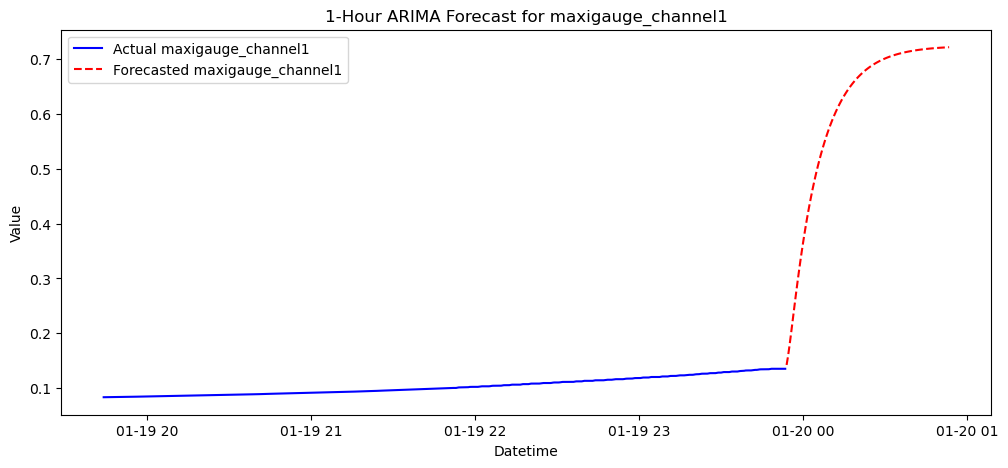

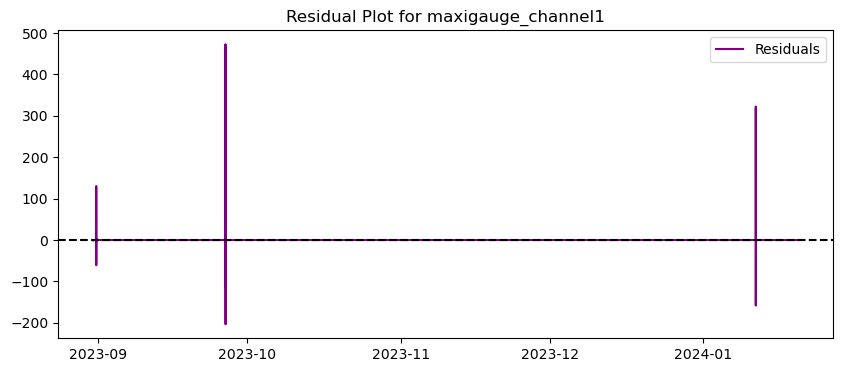


Processing ARIMA for maxigauge_channel2
ADF Statistic: -18.201313199194228, p-value: 2.4054632246083723e-30
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=608622.628, Time=19.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=729073.598, Time=0.81 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=702583.318, Time=0.90 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=630401.802, Time=4.61 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=729071.598, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=622317.006, Time=10.40 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=612622.360, Time=6.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=605356.860, Time=16.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=612344.170, Time=10.32 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=592881.234, Time=20.03 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=593387.044, Time=16.83 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=566195.005, Time=45.62 sec
 ARIMA(5,1,1)(0,0,0)[0] i

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for maxigauge_channel2:
Mean Absolute Error (MAE): 2.2495
Root Mean Squared Error (RMSE): 25.8182
Kolmogorov-Smirnov Statistic: 0.8775, p-value: 0.0000
Jensen-Shannon Divergence: 0.7884


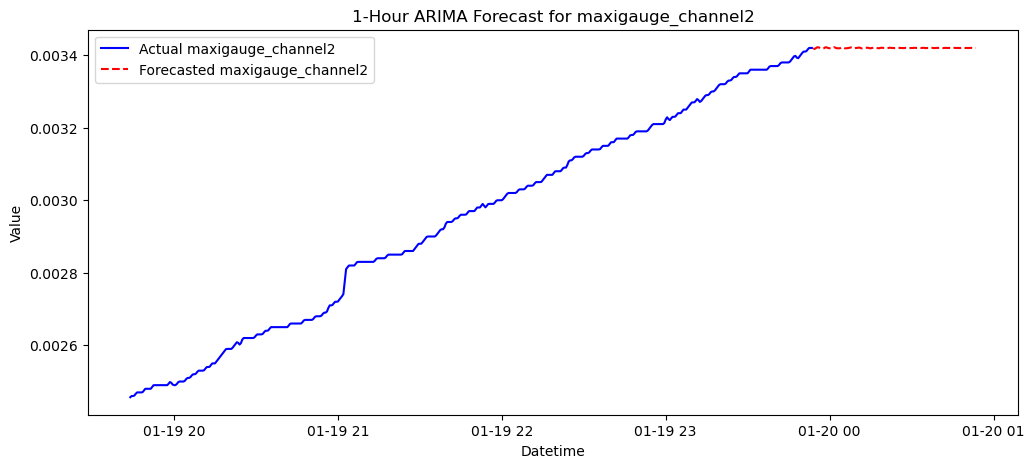

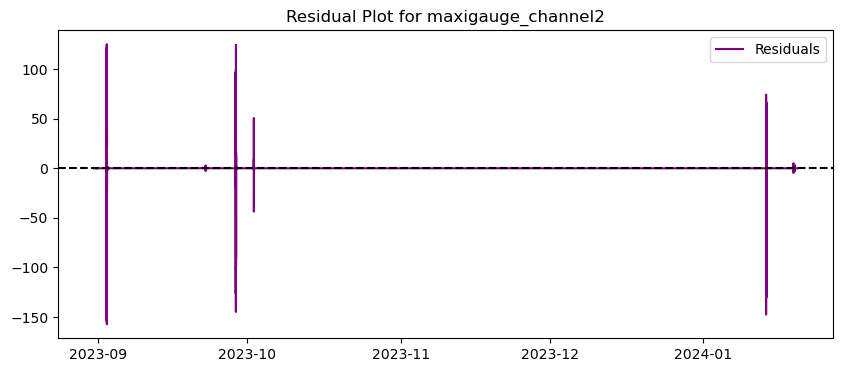


Processing ARIMA for maxigauge_channel6
ADF Statistic: -6.772668813714713, p-value: 2.617761813586707e-09
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=720987.820, Time=20.60 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=745297.988, Time=1.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=725536.541, Time=1.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=722006.498, Time=4.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=745296.282, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=721639.111, Time=21.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=721421.414, Time=5.72 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=720946.132, Time=30.79 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=721411.978, Time=26.02 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=720933.582, Time=47.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=720931.944, Time=33.46 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=721354.629, Time=1.79 sec
 ARIMA(5,1,1)(0,0,0)[0] inte

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati


Evaluation Metrics for maxigauge_channel6:
Mean Absolute Error (MAE): 1.2787
Root Mean Squared Error (RMSE): 1.5407
Kolmogorov-Smirnov Statistic: 0.8958, p-value: 0.0000
Jensen-Shannon Divergence: 0.2279


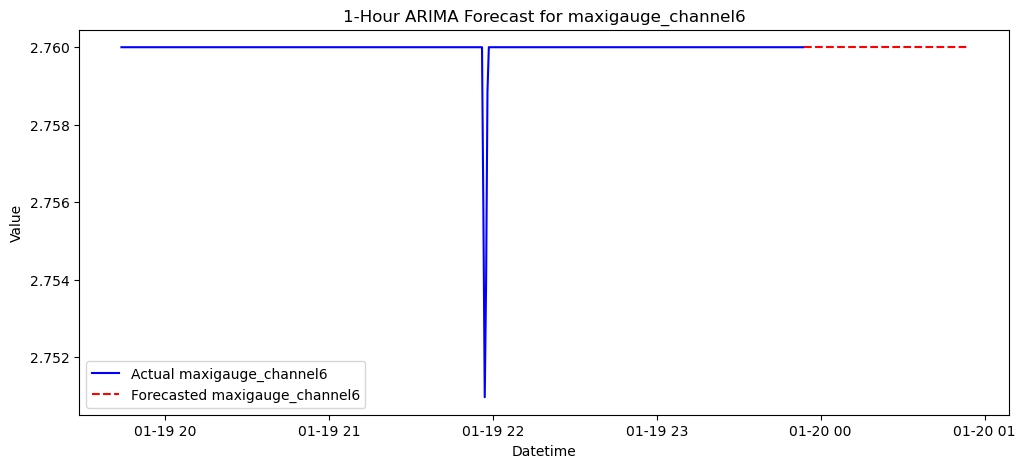

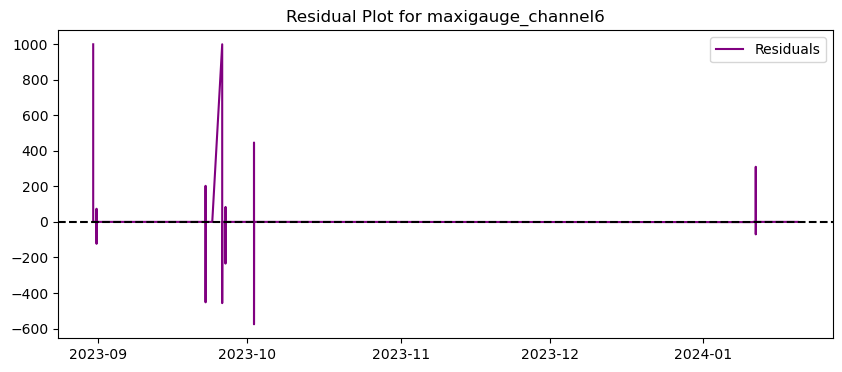

In [20]:
forecast_results = {}

for sensor in selected_channels:
    print(f"\nProcessing ARIMA for {sensor}")
    
    # Step 1: Load and clean data
    data = df[sensor].dropna()

    # Step 2: Ensure data is stationary
    data = check_stationarity(data)

    # Step 3: Find the optimal ARIMA parameters
    best_order = find_best_arima_params(data)
    print(f"Optimal ARIMA Order for {sensor}: {best_order}")
    
    # Step 4: Train the ARIMA model
    model = ARIMA(data, order=best_order)
    model_fit = model.fit()
    
    # Step 5: Forecast next 1 hour (120 steps at 30-second intervals)
    steps_ahead = 120
    forecast = model_fit.forecast(steps=steps_ahead)

    # Generate time index for the forecast
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(seconds=30), 
                                   periods=steps_ahead, 
                                   freq='30s')

    # Create DataFrame for forecast results
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    forecast_results[sensor] = forecast_df

    # Step 6: Evaluate Model Performance
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    forecast_test = model_fit.forecast(steps=len(test))

    # Compute MAE and RMSE
    mae = mean_absolute_error(test, forecast_test)
    rmse = np.sqrt(mean_squared_error(test, forecast_test))
    
    # KS test
    ks_stat, ks_p_value = ks_2samp(test, forecast_test)

    # Jensen-Shannon divergence (instead of KL)
    js_divergence = jensenshannon(test + 1e-10, forecast_test + 1e-10)

    # Print evaluation metrics
    print(f"\nEvaluation Metrics for {sensor}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
    print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

    # Step 7: Plot actual vs. forecasted values
    plt.figure(figsize=(12, 5))
    
    # Plot last 500 actual values
    plt.plot(data.index[-500:], data.values[-500:], label=f"Actual {sensor}", color='blue')
    
    # Plot full 1-hour forecast
    plt.plot(forecast_df.index, forecast_df["Forecasted Values"], label=f"Forecasted {sensor}", color='red', linestyle='dashed')
    
    plt.xlabel("Datetime")
    plt.ylabel("Value")
    plt.title(f"1-Hour ARIMA Forecast for {sensor}")
    plt.legend()
    plt.show()

    # Step 8: Plot Residuals
    residuals = model_fit.resid
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label="Residuals", color="purple")
    plt.axhline(y=0, linestyle="--", color="black")
    plt.title(f"Residual Plot for {sensor}")
    plt.legend()
    plt.show()

### For only one dataset

In [7]:
df1 = pd.read_csv("../databases/processed_data/cd230831.csv")

# Convert 'datetime' column to pandas datetime format and set as index
df1['datetime'] = pd.to_datetime(df1['datetime'])
df1.set_index('datetime', inplace=True)

# Selected channels for ARIMA modeling
selected_channels = ["maxigauge_channel1", "maxigauge_channel2", "maxigauge_channel6"]

In [ ]:
# Function to check and make data stationary
def check_stationarity(data):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(data)
    print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")
    
    if result[1] > 0.05:
        print("Data is NOT stationary, applying first-order differencing...")
        return data.diff().dropna()
    else:
        return data

# Function to find optimal ARIMA order
def find_best_arima_params(data):
    model = auto_arima(data, seasonal=False, trace=True, stepwise=True)
    return model.order


Processing ARIMA for maxigauge_channel1
ADF Statistic: -27.03856384773437, p-value: 0.0
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=24.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=285709.489, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=164544.076, Time=1.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=209475.272, Time=4.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=285707.489, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=150804.734, Time=1.68 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=150791.810, Time=1.93 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=149201.577, Time=2.18 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=148549.309, Time=2.60 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=146482.982, Time=20.66 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=147092.463, Time=13.64 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=32.67 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=134468.050, Time=23.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)



Evaluation Metrics for maxigauge_channel1:
Mean Absolute Error (MAE): 0.0143
Root Mean Squared Error (RMSE): 0.0169
Kolmogorov-Smirnov Statistic: 0.7173, p-value: 0.0000
Jensen-Shannon Divergence: 0.5934


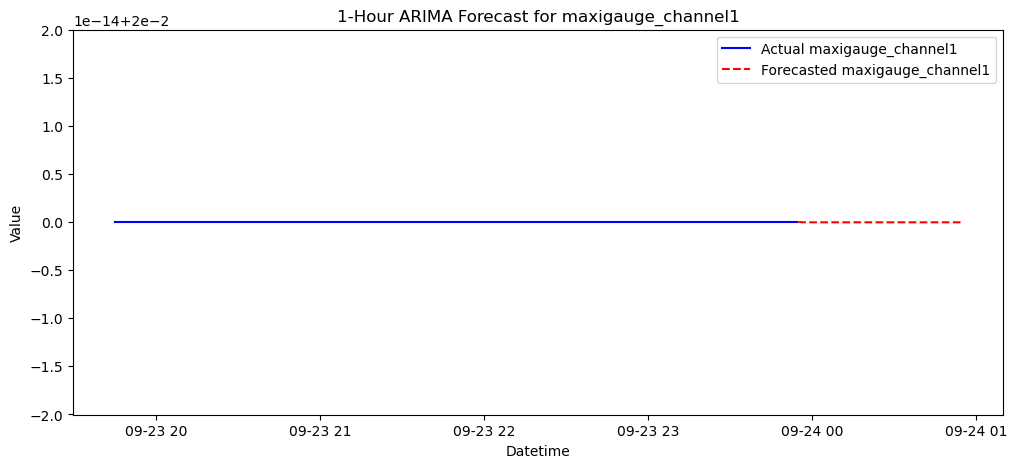

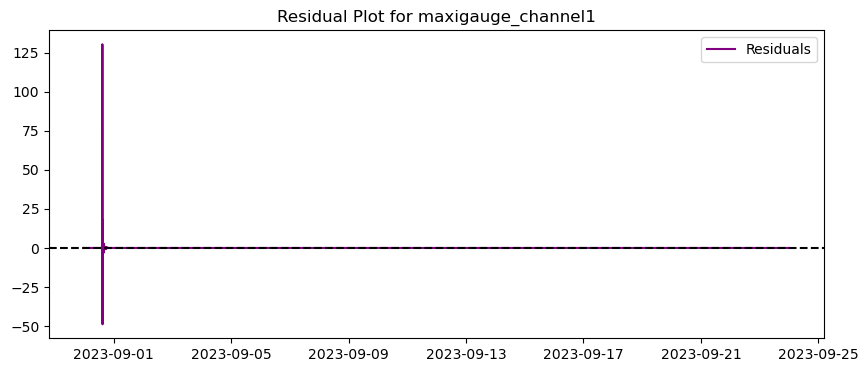


Processing ARIMA for maxigauge_channel2
ADF Statistic: -14.876775354616514, p-value: 1.632040629236807e-27
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=283028.070, Time=23.81 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=350438.678, Time=0.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=320711.514, Time=0.53 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=290945.718, Time=2.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=350436.678, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=287410.161, Time=10.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=287354.070, Time=4.76 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=282728.098, Time=10.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=287223.594, Time=7.60 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=282334.191, Time=23.72 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=287041.396, Time=9.37 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=281916.224, Time=18.61 sec
 ARIMA(5,1,1)(0,0,0)[0] inte

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)



Evaluation Metrics for maxigauge_channel2:
Mean Absolute Error (MAE): 0.0698
Root Mean Squared Error (RMSE): 0.5957
Kolmogorov-Smirnov Statistic: 0.7338, p-value: 0.0000
Jensen-Shannon Divergence: 0.6099


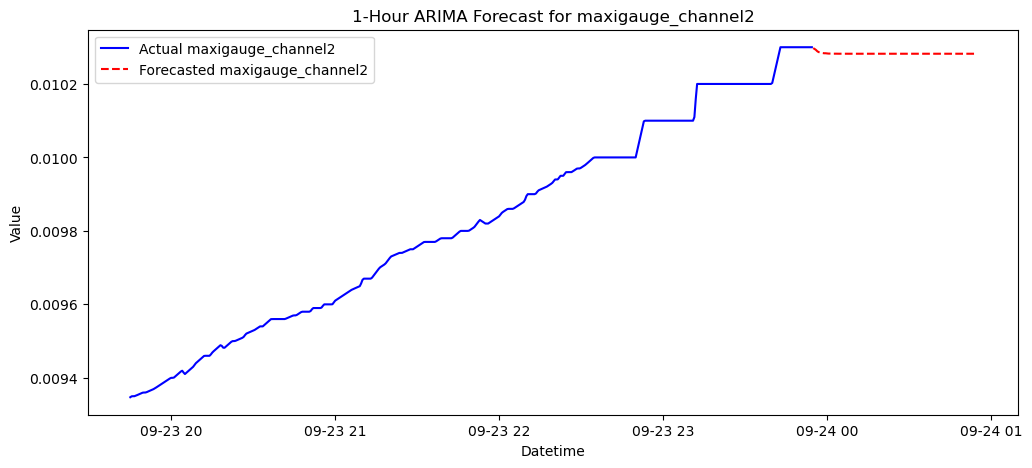

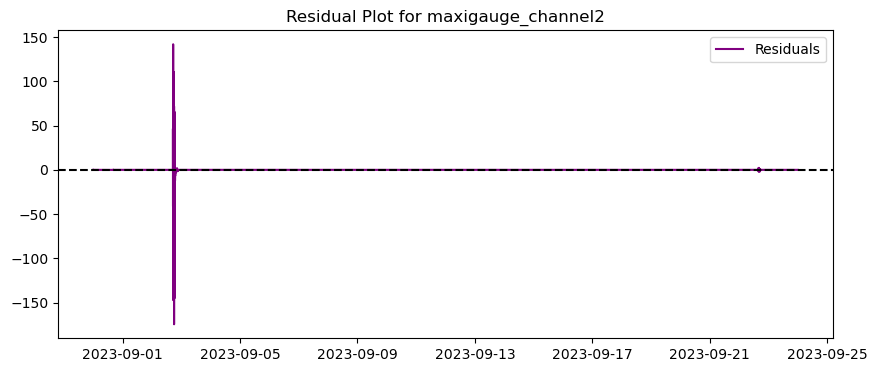


Processing ARIMA for maxigauge_channel6
ADF Statistic: -6.312096984444018, p-value: 3.215942156617052e-08
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=283773.164, Time=14.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=367474.964, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=325544.472, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=298436.837, Time=3.77 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=367474.169, Time=0.28 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=283718.292, Time=20.58 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=283724.683, Time=3.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=285369.080, Time=3.91 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=283491.023, Time=18.16 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=283722.186, Time=4.75 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=283331.972, Time=15.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=282098.616, Time=32.90 sec
 ARIMA(3,1,2)(0,0,0)[0] inter

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)



Evaluation Metrics for maxigauge_channel6:
Mean Absolute Error (MAE): 4.9977
Root Mean Squared Error (RMSE): 13.2575
Kolmogorov-Smirnov Statistic: 0.7199, p-value: 0.0000
Jensen-Shannon Divergence: 0.2772


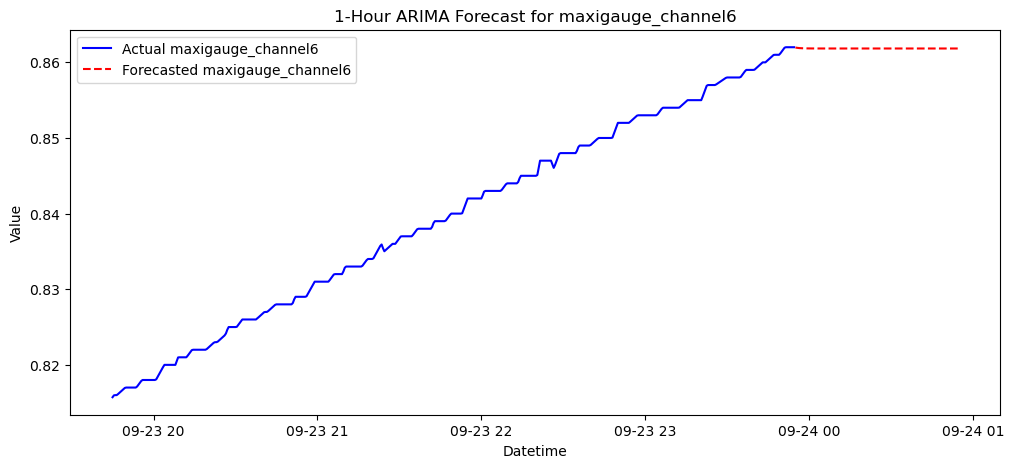

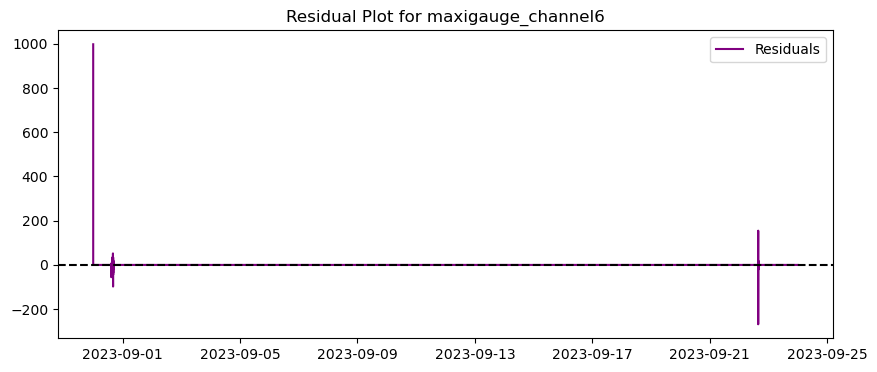

In [9]:
forecast_results = {}

for sensor in selected_channels:
    print(f"\nProcessing ARIMA for {sensor}")
    
    # Step 1: Load and clean data
    data = df1[sensor].dropna()

    # Step 2: Ensure data is stationary
    data = check_stationarity(data)

    # Step 3: Find the optimal ARIMA parameters
    best_order = find_best_arima_params(data)
    print(f"Optimal ARIMA Order for {sensor}: {best_order}")
    
    # Step 4: Train the ARIMA model
    model = ARIMA(data, order=best_order)
    model_fit = model.fit()
    
    # Step 5: Forecast next 1 hour (120 steps at 30-second intervals)
    steps_ahead = 120
    forecast = model_fit.forecast(steps=steps_ahead)

    # Generate time index for the forecast
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(seconds=30), 
                                   periods=steps_ahead, 
                                   freq='30s')

    # Create DataFrame for forecast results
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    forecast_results[sensor] = forecast_df

    # Step 6: Evaluate Model Performance
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    forecast_test = model_fit.forecast(steps=len(test))

    # Compute MAE and RMSE
    mae = mean_absolute_error(test, forecast_test)
    rmse = np.sqrt(mean_squared_error(test, forecast_test))
    
    # KS test
    ks_stat, ks_p_value = ks_2samp(test, forecast_test)

    # Jensen-Shannon divergence (instead of KL)
    js_divergence = jensenshannon(test + 1e-10, forecast_test + 1e-10)

    # Print evaluation metrics
    print(f"\nEvaluation Metrics for {sensor}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
    print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

    # Step 7: Plot actual vs. forecasted values
    plt.figure(figsize=(12, 5))
    
    # Plot last 500 actual values
    plt.plot(data.index[-500:], data.values[-500:], label=f"Actual {sensor}", color='blue')
    
    # Plot full 1-hour forecast
    plt.plot(forecast_df.index, forecast_df["Forecasted Values"], label=f"Forecasted {sensor}", color='red', linestyle='dashed')
    
    plt.xlabel("Datetime")
    plt.ylabel("Value")
    plt.title(f"1-Hour ARIMA Forecast for {sensor}")
    plt.legend()
    plt.show()

    # Step 8: Plot Residuals
    residuals = model_fit.resid
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label="Residuals", color="purple")
    plt.axhline(y=0, linestyle="--", color="black")
    plt.title(f"Residual Plot for {sensor}")
    plt.legend()
    plt.show()


📊 Processing ARIMA for maxigauge_channel1
✅ Optimal ARIMA Order for maxigauge_channel1: (0, 1, 0)


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_65484/242780388.py:48: FutureWarning: 'S' is deprecated and wil


📉 Evaluation Metrics for maxigauge_channel1:
📌 MAE: 0.0000
📌 RMSE: 0.0000
📌 Kolmogorov-Smirnov Test: 0.6145 (p-value: 0.0000)
📌 Jensen-Shannon Divergence: 0.0145


/Users/liqi/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


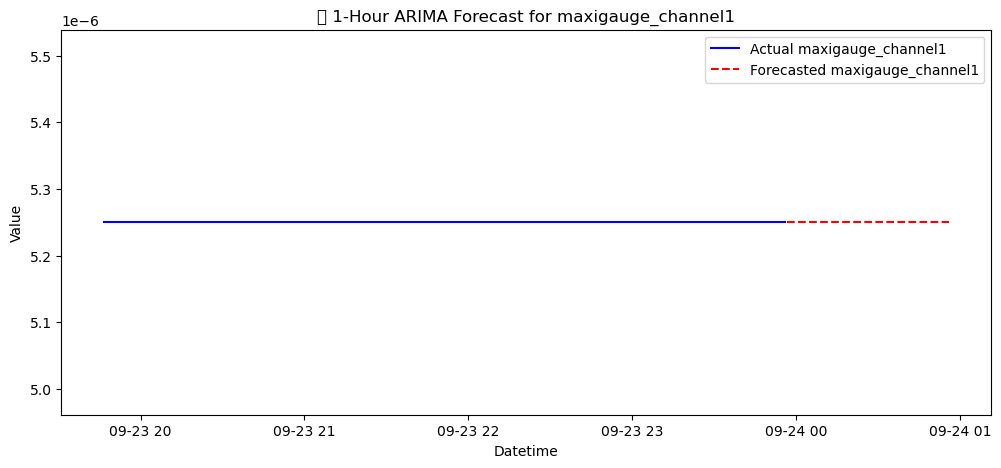

/Users/liqi/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


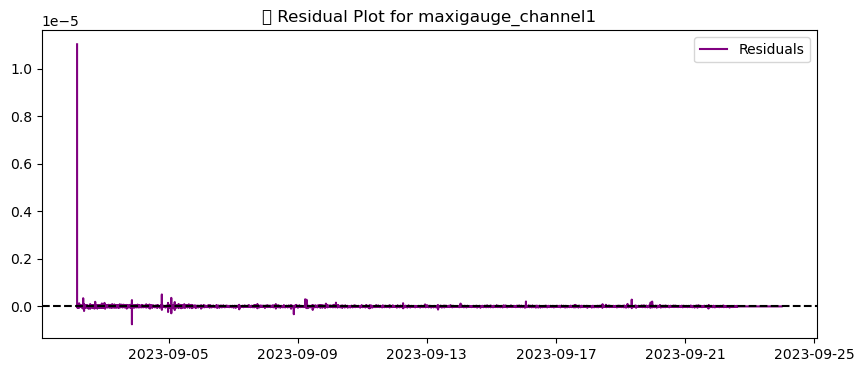


📊 Processing ARIMA for maxigauge_channel2


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


✅ Optimal ARIMA Order for maxigauge_channel2: (4, 1, 4)


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_65484/242780388.py:48: FutureWarning: 'S' is deprecated and wil


📉 Evaluation Metrics for maxigauge_channel2:
📌 MAE: 0.0004
📌 RMSE: 0.0005
📌 Kolmogorov-Smirnov Test: 0.6783 (p-value: 0.0000)
📌 Jensen-Shannon Divergence: 0.0051


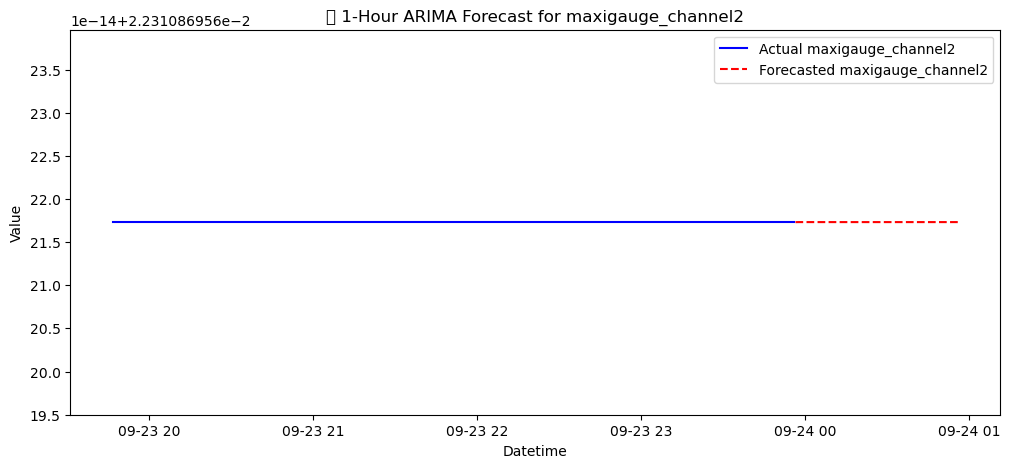

/Users/liqi/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


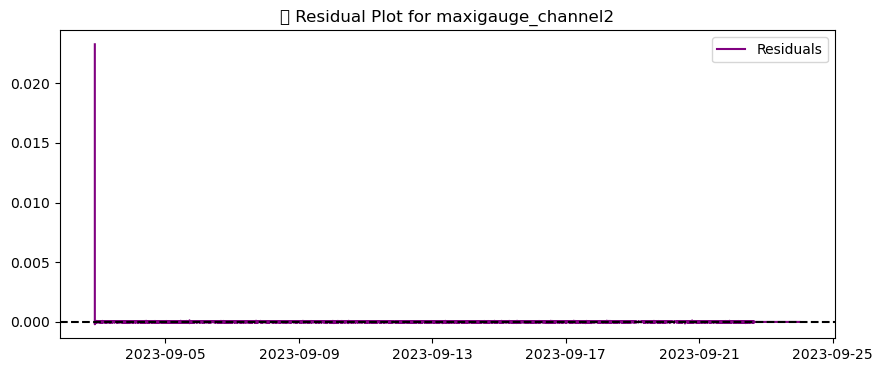


📊 Processing ARIMA for maxigauge_channel6
✅ Optimal ARIMA Order for maxigauge_channel6: (5, 0, 1)


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: Us


📉 Evaluation Metrics for maxigauge_channel6:
📌 MAE: 0.0023
📌 RMSE: 0.0257
📌 Kolmogorov-Smirnov Test: 0.5495 (p-value: 0.0000)
📌 Jensen-Shannon Divergence: inf


/var/folders/k8/13s2hdrn4j3c1707gnj300r80000gn/T/ipykernel_65484/242780388.py:48: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(seconds=30),
/Users/liqi/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


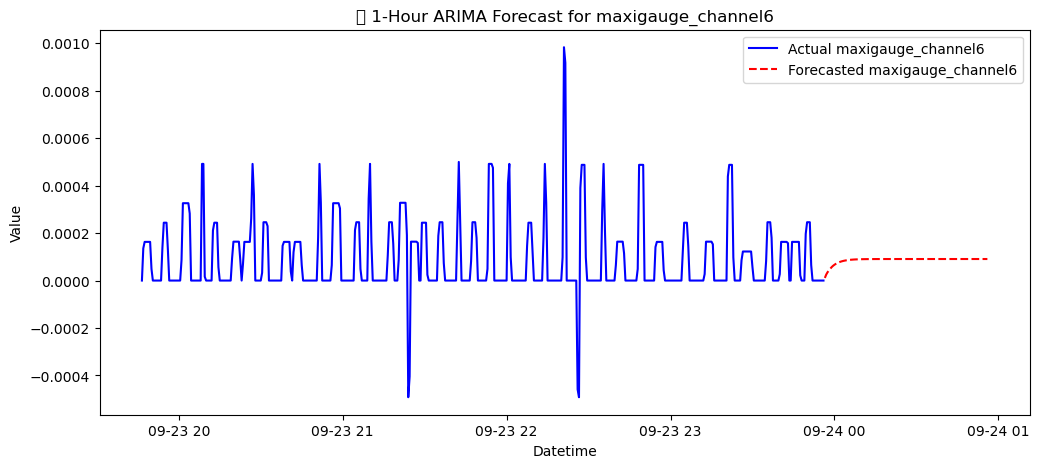

/Users/liqi/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


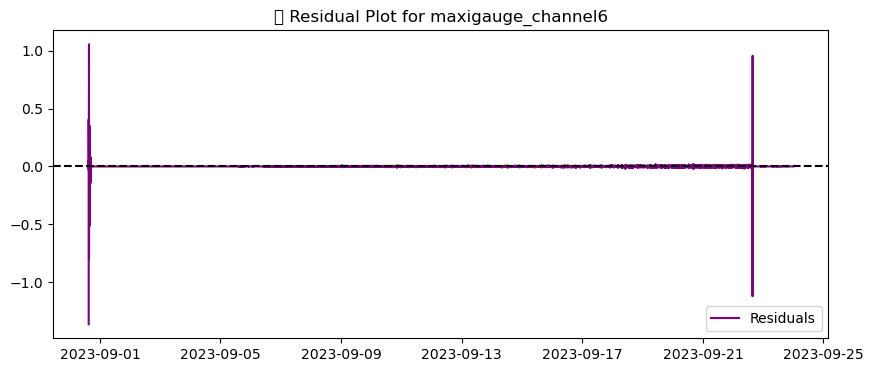

In [15]:
def check_stationarity(series, max_diff=2):
    """Ensure data is stationary by applying differencing (d no more than 2)."""
    series = series.ffill().bfill()  # Handle missing values
    d = min(ndiffs(series, test='adf', max_d=max_diff), max_diff)  # Limit d to max 2
    return series.diff(d).dropna() if d > 0 else series

def find_best_arima_params(series, max_d=2):
    """Automatically find the best ARIMA parameters, limiting d ≤ 2."""
    try:
        model = auto_arima(series, seasonal=False, stepwise=True, 
                           max_d=max_d, trace=False, suppress_warnings=True)
        return model.order
    except Exception as e:
        print(f"⚠️ ARIMA parameter search failed: {e}")
        return (1, 1, 1)  # Default fallback

forecast_results = {}

for sensor in selected_channels:
    print(f"\n📊 Processing ARIMA for {sensor}")

    # Step 1: Load and clean data
    data = df1[sensor].dropna()
    if data.empty:
        print(f"⚠️ No data available for {sensor}, skipping...")
        continue

    # Step 2: Ensure stationarity (d is limited to max 2)
    data = check_stationarity(data, max_diff=2)
    data = data.asfreq('30S')  # Set frequency to 30 seconds

    # Step 3: Find optimal ARIMA parameters
    best_order = find_best_arima_params(data, max_d=2)
    print(f"✅ Optimal ARIMA Order for {sensor}: {best_order}")

    # Step 4: Train ARIMA model
    try:
        model = ARIMA(data, order=best_order)
        model_fit = model.fit()
    except Exception as e:
        print(f"⚠️ ARIMA model fitting failed for {sensor}: {e}")
        continue

    # Step 5: Forecast next 1 hour (120 steps at 30-second intervals)
    steps_ahead = 120
    forecast = model_fit.forecast(steps=steps_ahead)

    # Generate time index for forecast
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(seconds=30), 
                                   periods=steps_ahead, 
                                   freq='30s')

    # Store forecast results
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    forecast_results[sensor] = forecast_df

    # Step 6: Evaluate Model Performance
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]

    try:
        forecast_test = model_fit.forecast(steps=len(test))

        # Compute MAE and RMSE
        mae = mean_absolute_error(test, forecast_test)
        rmse = np.sqrt(mean_squared_error(test, forecast_test))

        # Kolmogorov-Smirnov Test
        ks_stat, ks_p_value = ks_2samp(test, forecast_test)

        # Jensen-Shannon Divergence (avoid log errors)
        js_divergence = jensenshannon(test + 1e-10, forecast_test + 1e-10)
    except Exception as e:
        print(f"⚠️ Evaluation metrics calculation failed: {e}")
        continue

    # Print evaluation metrics
    print(f"\n📉 Evaluation Metrics for {sensor}:")
    print(f"📌 MAE: {mae:.4f}")
    print(f"📌 RMSE: {rmse:.4f}")
    print(f"📌 Kolmogorov-Smirnov Test: {ks_stat:.4f} (p-value: {ks_p_value:.4f})")
    print(f"📌 Jensen-Shannon Divergence: {js_divergence:.4f}")

    # Step 7: Plot Actual vs Forecast
    plt.figure(figsize=(12, 5))
    plt.plot(data.index[-500:], data.values[-500:], label=f"Actual {sensor}", color='blue')
    plt.plot(forecast_df.index, forecast_df["Forecasted Values"], 
             label=f"Forecasted {sensor}", color='red', linestyle='dashed')
    plt.xlabel("Datetime")
    plt.ylabel("Value")
    plt.title(f"📈 1-Hour ARIMA Forecast for {sensor}")
    plt.legend()
    plt.show()

    # Step 8: Plot Residuals
    residuals = model_fit.resid
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label="Residuals", color="purple")
    plt.axhline(y=0, linestyle="--", color="black")
    plt.title(f"📉 Residual Plot for {sensor}")
    plt.legend()
    plt.show()

## Selected Channels with Outlier Handling

In [36]:
def cap_outliers(df, iqr_multiplier=1.5):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        # Replace outliers with NaN
        mask = (df[column] < lower_bound) | (df[column] > upper_bound)
        df.loc[mask, column] = np.nan
        
        # Assign interpolated values back to the DataFrame
        df[column] = df[column].interpolate(method='linear')
    
    return df

# Apply to your DataFrame
outliers_df = cap_outliers(df)


Processing ARIMA for maxigauge_channel1
ADF Statistic: -2.11336976908521, p-value: 0.23917264525946247
Data is NOT stationary, applying first-order differencing...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-2965003.005, Time=7.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2445385.741, Time=1.48 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-2963743.707, Time=3.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-2975641.349, Time=3.32 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-2956111.685, Time=4.30 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-2961190.753, Time=4.70 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-2958719.965, Time=5.84 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2796145.855, Time=10.71 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 40.514 seconds
Optimal ARIMA Order for maxigauge_channel1: (0, 0, 1)


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for maxigauge_channel1:
Mean Absolute Error (MAE): 0.0000
Root Mean Squared Error (RMSE): 0.0000
Kolmogorov-Smirnov Statistic: 1.0000, p-value: 0.0000
Jensen-Shannon Divergence: inf


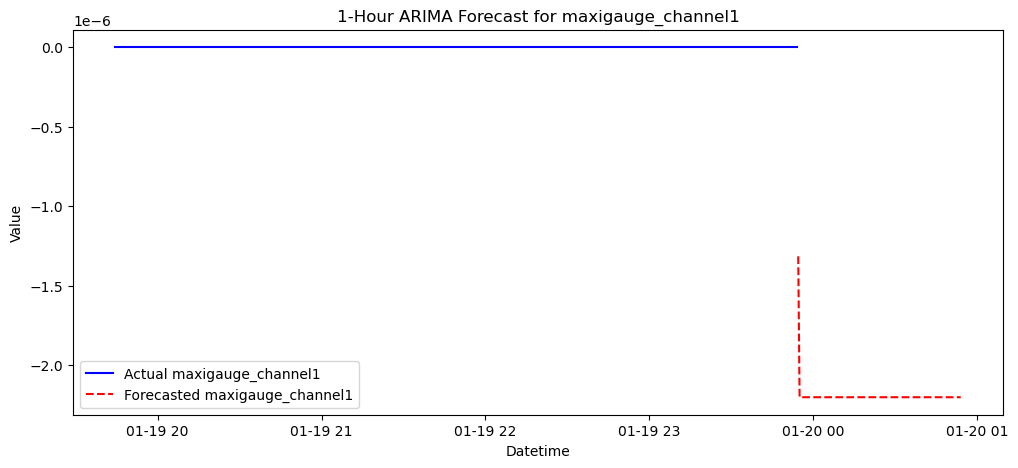

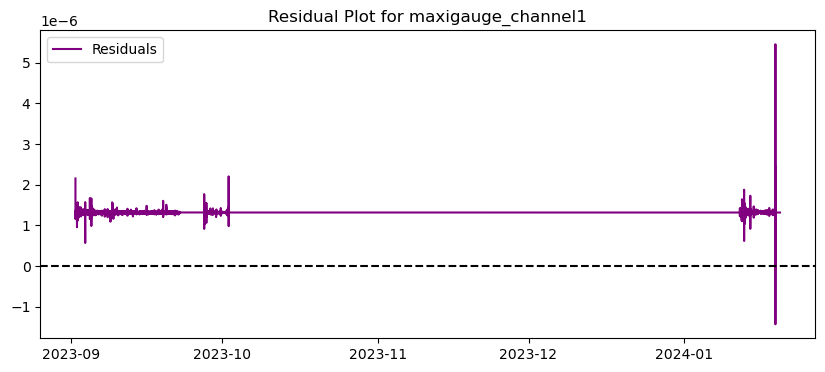


Processing ARIMA for maxigauge_channel2
ADF Statistic: -4.660745987528579, p-value: 9.966396389900059e-05
Performing stepwise search to minimize aic


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2129865.483, Time=15.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2137766.604, Time=4.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2173590.802, Time=6.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2183243.703, Time=17.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2125269.797, Time=1.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2186459.541, Time=22.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2186934.686, Time=9.95 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-2186138.530, Time=8.18 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-2187147.927, Time=29.51 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-2186628.865, Time=9.94 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-2187403.872, Time=15.03 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-2188122.043, Time=13.01 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-2188319.513, Time=15.94 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-2187966.310, Time=17.80 sec
 ARIMA(5,1,0

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for maxigauge_channel2:
Mean Absolute Error (MAE): 0.0017
Root Mean Squared Error (RMSE): 0.0018
Kolmogorov-Smirnov Statistic: 0.9286, p-value: 0.0000
Jensen-Shannon Divergence: 0.0092


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


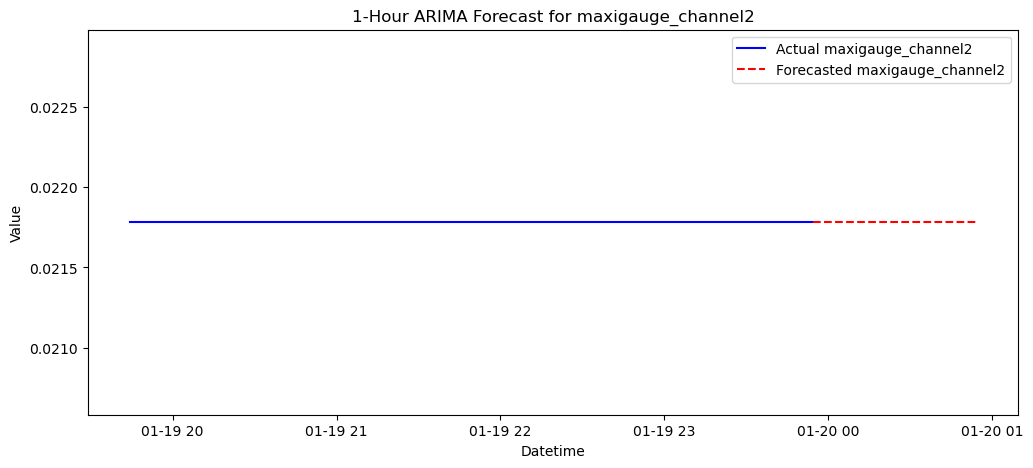

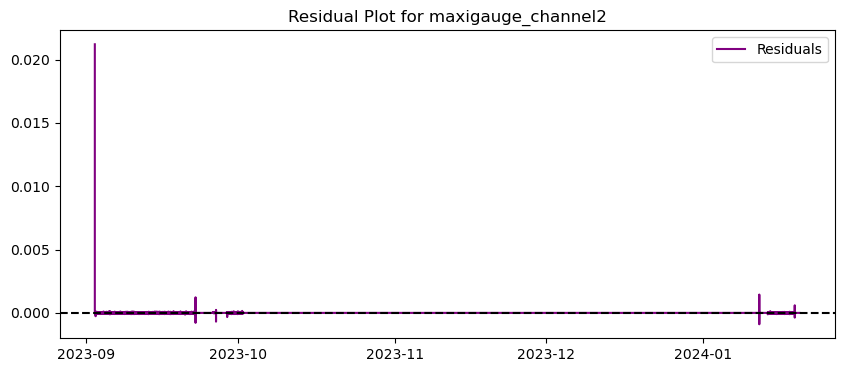


Processing ARIMA for maxigauge_channel6
ADF Statistic: -2.1858609701754825, p-value: 0.21141707109399988
Data is NOT stationary, applying first-order differencing...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-738688.295, Time=11.71 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-608310.151, Time=1.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-735163.448, Time=1.94 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-683109.274, Time=2.38 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-737181.916, Time=3.25 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-736581.673, Time=3.33 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-738297.479, Time=5.31 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-738650.772, Time=2.56 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-736468.482, Time=5.26 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-738523.533, Time=1.85 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-737799.920, Time=9.59 sec
 ARIMA(3,0,3)(0,0,0)[0]       

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r


Evaluation Metrics for maxigauge_channel6:
Mean Absolute Error (MAE): 0.0004
Root Mean Squared Error (RMSE): 0.0012
Kolmogorov-Smirnov Statistic: 0.9442, p-value: 0.0000
Jensen-Shannon Divergence: inf


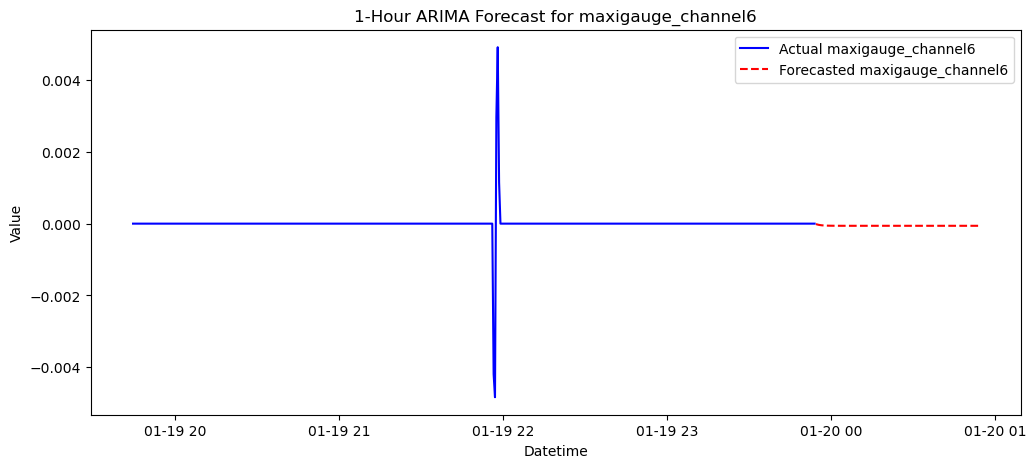

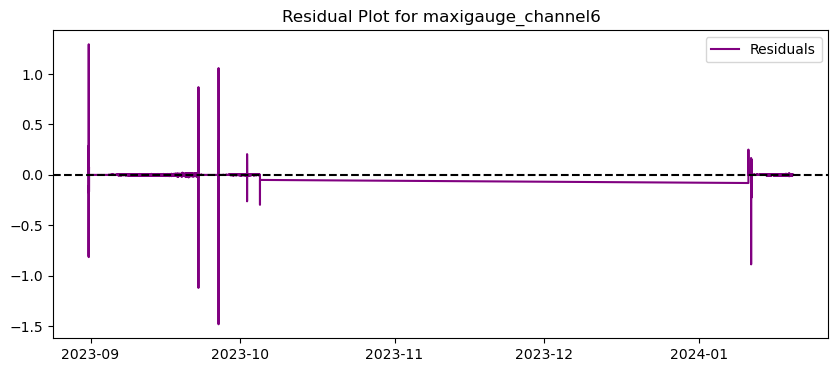

In [ ]:
forecast_results = {}

for sensor in selected_channels:
    print(f"\nProcessing ARIMA for {sensor}")
    
    # Step 1: Load and clean data
    data = outliers_df[sensor].dropna()

    # Step 2: Ensure data is stationary
    data = check_stationarity(data)

    # Step 3: Find the optimal ARIMA parameters
    best_order = find_best_arima_params(data)
    print(f"Optimal ARIMA Order for {sensor}: {best_order}")
    
    # Step 4: Train the ARIMA model
    model = ARIMA(data, order=best_order)
    model_fit = model.fit()
    
    # Step 5: Forecast next 1 hour (120 steps at 30-second intervals)
    steps_ahead = 120
    forecast = model_fit.forecast(steps=steps_ahead)

    # Generate time index for the forecast
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(seconds=30), 
                                   periods=steps_ahead, 
                                   freq='30s')

    # Create DataFrame for forecast results
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    forecast_results[sensor] = forecast_df

    # Step 6: Evaluate Model Performance
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    forecast_test = model_fit.forecast(steps=len(test))

    # Compute MAE and RMSE
    mae = mean_absolute_error(test, forecast_test)
    rmse = np.sqrt(mean_squared_error(test, forecast_test))
    
    # KS test
    ks_stat, ks_p_value = ks_2samp(test, forecast_test)

    # Jensen-Shannon divergence (instead of KL)
    js_divergence = jensenshannon(test + 1e-10, forecast_test + 1e-10)

    # Print evaluation metrics
    print(f"\nEvaluation Metrics for {sensor}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
    print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

    # Step 7: Plot actual vs. forecasted values
    plt.figure(figsize=(12, 5))
    
    # Plot last 500 actual values
    plt.plot(data.index[-500:], data.values[-500:], label=f"Actual {sensor}", color='blue')
    
    # Plot full 1-hour forecast
    plt.plot(forecast_df.index, forecast_df["Forecasted Values"], label=f"Forecasted {sensor}", color='red', linestyle='dashed')
    
    plt.xlabel("Datetime")
    plt.ylabel("Value")
    plt.title(f"1-Hour ARIMA Forecast for {sensor}")
    plt.legend()
    plt.show()

    # Step 8: Plot Residuals
    residuals = model_fit.resid
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label="Residuals", color="purple")
    plt.axhline(y=0, linestyle="--", color="black")
    plt.title(f"Residual Plot for {sensor}")
    plt.legend()
    plt.show()

#### for only one dataset

In [10]:
def cap_outliers(df, iqr_multiplier=1.5):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        # Replace outliers with NaN
        mask = (df[column] < lower_bound) | (df[column] > upper_bound)
        df.loc[mask, column] = np.nan
        
        # Assign interpolated values back to the DataFrame
        df[column] = df[column].interpolate(method='linear')
    
    return df

# Apply to your DataFrame
outliers_df1 = cap_outliers(df1)

In [11]:
# Function to check and make data stationary
def check_stationarity(data):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(data)
    print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")
    
    if result[1] > 0.05:
        print("Data is NOT stationary, applying first-order differencing...")
        return data.diff().dropna()
    else:
        return data

# Function to find optimal ARIMA order
def find_best_arima_params(data):
    model = auto_arima(data, seasonal=False, trace=True, stepwise=True)
    return model.order


Processing ARIMA for maxigauge_channel1
ADF Statistic: -4.336678268275001, p-value: 0.00038354566385720754
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1351891.602, Time=25.95 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1386535.397, Time=5.88 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1386531.536, Time=6.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1386533.603, Time=7.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1443602.892, Time=1.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1392735.095, Time=5.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 52.825 seconds
Optimal ARIMA Order for maxigauge_channel1: (0, 1, 0)


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Evaluation Metrics for maxigauge_channel1:
Mean Absolute Error (MAE): 0.0000
Root Mean Squared Error (RMSE): 0.0000
Kolmogorov-Smirnov Statistic: 0.6145, p-value: 0.0000
Jensen-Shannon Divergence: 0.0145


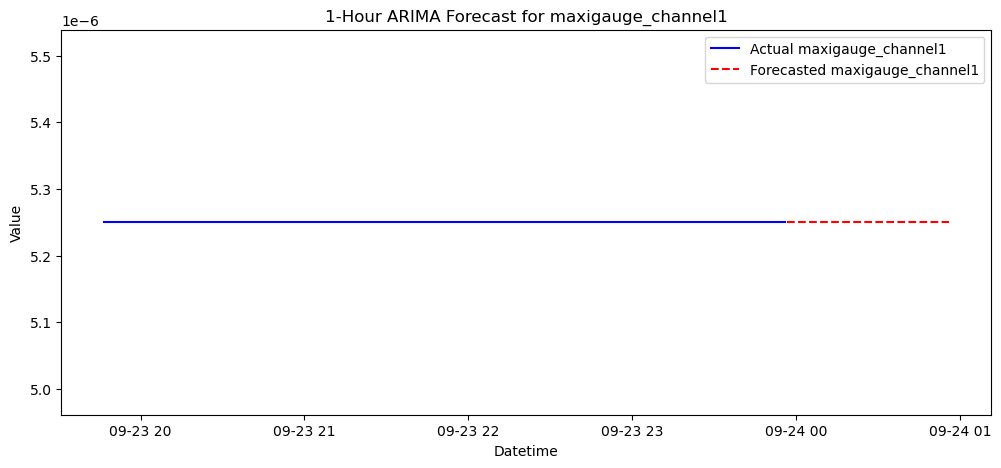

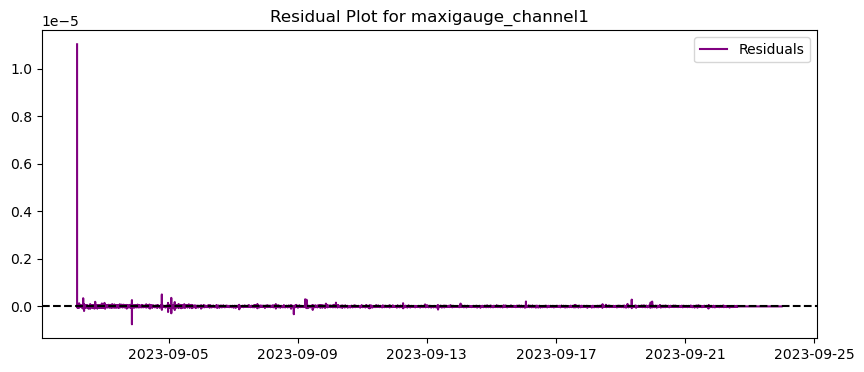


Processing ARIMA for maxigauge_channel2
ADF Statistic: -5.096131913653154, p-value: 1.4272250320488003e-05
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1199313.538, Time=6.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1146020.648, Time=6.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1174156.201, Time=9.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1198473.578, Time=12.43 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1137283.034, Time=1.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1198412.003, Time=14.24 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1191096.698, Time=15.41 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1201606.525, Time=7.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1192035.752, Time=6.70 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-1201669.793, Time=10.39 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-1197791.403, Time=30.06 sec


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=2813343275.383, Time=13.65 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-1203517.399, Time=85.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1203365.969, Time=54.49 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-1201988.494, Time=35.18 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-1204437.122, Time=162.71 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-1203814.023, Time=12.27 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=9.34 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=-1202730.657, Time=58.66 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=-1203473.845, Time=15.21 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=-1201526.869, Time=82.79 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=-1202277.510, Time=8.77 sec

Best model:  ARIMA(4,1,4)(0,0,0)[0] intercept
Total fit time: 659.006 seconds
Optimal ARIMA Order for maxigauge_channel2: (4, 1, 4)


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



Evaluation Metrics for maxigauge_channel2:
Mean Absolute Error (MAE): 0.0004
Root Mean Squared Error (RMSE): 0.0005
Kolmogorov-Smirnov Statistic: 0.6783, p-value: 0.0000
Jensen-Shannon Divergence: 0.0051


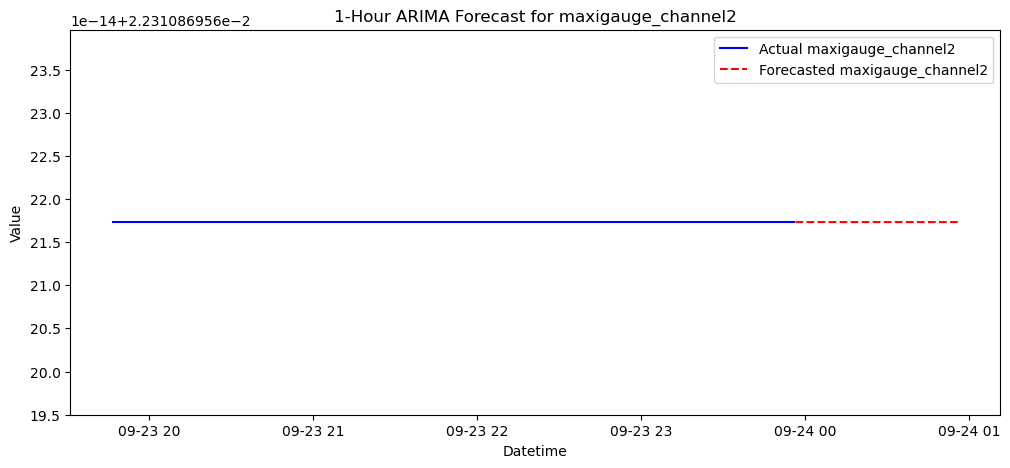

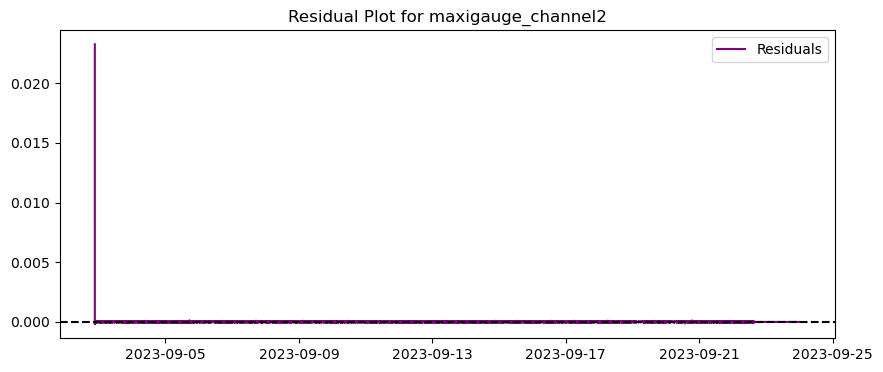


Processing ARIMA for maxigauge_channel6
ADF Statistic: -1.940850878692321, p-value: 0.3130941907603974
Data is NOT stationary, applying first-order differencing...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-423274.204, Time=7.58 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-327331.983, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-414065.688, Time=1.95 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-384453.111, Time=2.75 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-422929.164, Time=6.18 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-422889.008, Time=5.15 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-424044.898, Time=8.18 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-421913.065, Time=7.48 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-424705.817, Time=11.82 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-423990.560, Time=10.27 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-424261.259, Time=13.33 sec
 ARIMA(4,0,3)(0,0,0)[0]       

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 30s will be used.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: Us


Evaluation Metrics for maxigauge_channel6:
Mean Absolute Error (MAE): 0.0023
Root Mean Squared Error (RMSE): 0.0257
Kolmogorov-Smirnov Statistic: 0.5495, p-value: 0.0000
Jensen-Shannon Divergence: inf


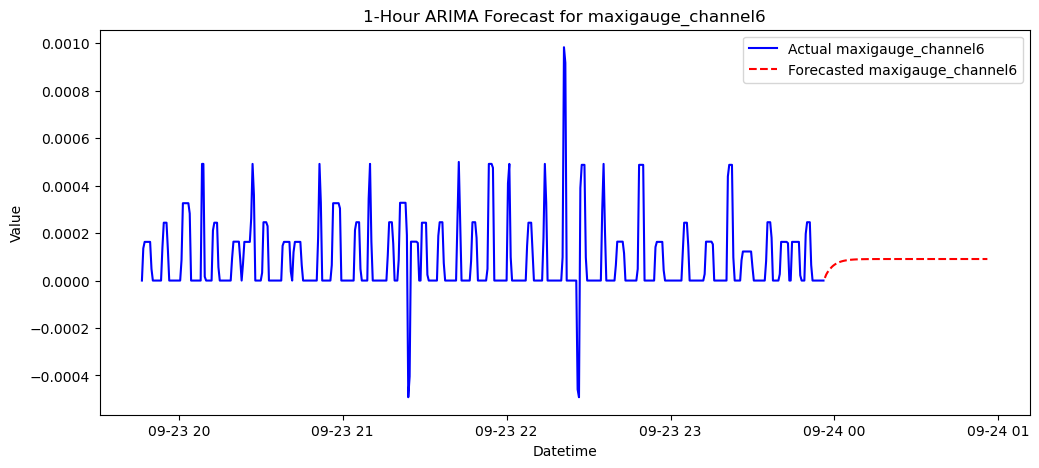

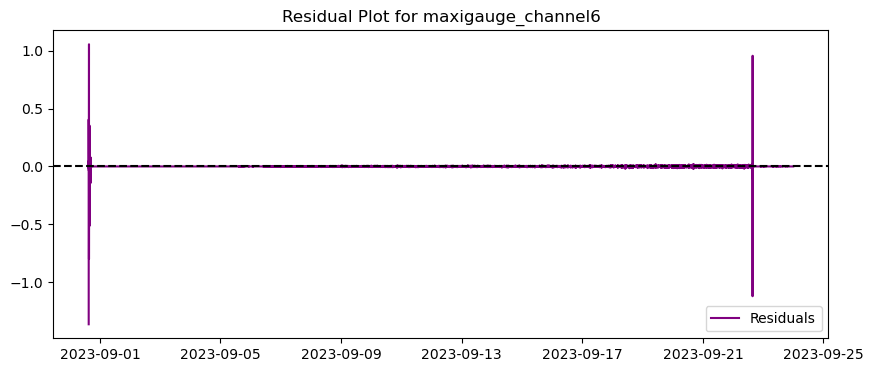

In [12]:
forecast_results = {}

for sensor in selected_channels:
    print(f"\nProcessing ARIMA for {sensor}")
    
    # Step 1: Load and clean data
    data = outliers_df1[sensor].dropna()

    # Step 2: Ensure data is stationary
    data = check_stationarity(data)

    # Step 3: Find the optimal ARIMA parameters
    best_order = find_best_arima_params(data)
    print(f"Optimal ARIMA Order for {sensor}: {best_order}")
    
    # Step 4: Train the ARIMA model
    model = ARIMA(data, order=best_order)
    model_fit = model.fit()
    
    # Step 5: Forecast next 1 hour (120 steps at 30-second intervals)
    steps_ahead = 120
    forecast = model_fit.forecast(steps=steps_ahead)

    # Generate time index for the forecast
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(seconds=30), 
                                   periods=steps_ahead, 
                                   freq='30s')

    # Create DataFrame for forecast results
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    forecast_results[sensor] = forecast_df

    # Step 6: Evaluate Model Performance
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    forecast_test = model_fit.forecast(steps=len(test))

    # Compute MAE and RMSE
    mae = mean_absolute_error(test, forecast_test)
    rmse = np.sqrt(mean_squared_error(test, forecast_test))
    
    # KS test
    ks_stat, ks_p_value = ks_2samp(test, forecast_test)

    # Jensen-Shannon divergence (instead of KL)
    js_divergence = jensenshannon(test + 1e-10, forecast_test + 1e-10)

    # Print evaluation metrics
    print(f"\nEvaluation Metrics for {sensor}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
    print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

    # Step 7: Plot actual vs. forecasted values
    plt.figure(figsize=(12, 5))
    
    # Plot last 500 actual values
    plt.plot(data.index[-500:], data.values[-500:], label=f"Actual {sensor}", color='blue')
    
    # Plot full 1-hour forecast
    plt.plot(forecast_df.index, forecast_df["Forecasted Values"], label=f"Forecasted {sensor}", color='red', linestyle='dashed')
    
    plt.xlabel("Datetime")
    plt.ylabel("Value")
    plt.title(f"1-Hour ARIMA Forecast for {sensor}")
    plt.legend()
    plt.show()

    # Step 8: Plot Residuals
    residuals = model_fit.resid
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label="Residuals", color="purple")
    plt.axhline(y=0, linestyle="--", color="black")
    plt.title(f"Residual Plot for {sensor}")
    plt.legend()
    plt.show()

### p,d,q <= 2

In [35]:
# Function to find best arima parameters with d constrained to ≤2, and p, q ≤ 2
def find_best_arima_params_3(series):
    """Finds the best ARIMA parameters with d constrained to ≤2."""
    series = series.dropna()

    if len(series) < 10:
        raise ValueError(f"Not enough data for ARIMA: {len(series)} points available.")
    if series.nunique() == 1:
        raise ValueError(f"{series.name} contains only one unique value, ARIMA cannot be trained.")
    try:
        auto_arima_model = auto_arima(series, seasonal=False, max_d=2, max_p=2, max_q=2,
                                      suppress_warnings=True, stepwise=True, trace=True)
        return auto_arima_model.order
    except Exception as e:
        print(f"Auto ARIMA failed for {series.name}: {e}")
        return (1, 0, 1)  # Default fallback ARIMA(1,0,1)


Processing ARIMA for maxigauge_channel1
ADF Statistic: -2.1415446227758497, p-value: 0.228140602255253
Data is NOT stationary, applying first-order differencing...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-3018300.662, Time=7.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2497189.725, Time=1.45 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-3019633.985, Time=3.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-3032169.469, Time=3.40 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-3010689.442, Time=4.34 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-3013082.784, Time=4.84 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-3015817.410, Time=5.91 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2497184.997, Time=6.74 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 36.897 seconds
Optimal ARIMA Order for maxigauge_channel1: (0, 0, 1)


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat


Evaluation Metrics for maxigauge_channel1:
Mean Absolute Error (MAE): 0.0000
Root Mean Squared Error (RMSE): 0.0000
Kolmogorov-Smirnov Statistic: 0.6408, p-value: 0.0000
Jensen-Shannon Divergence: inf


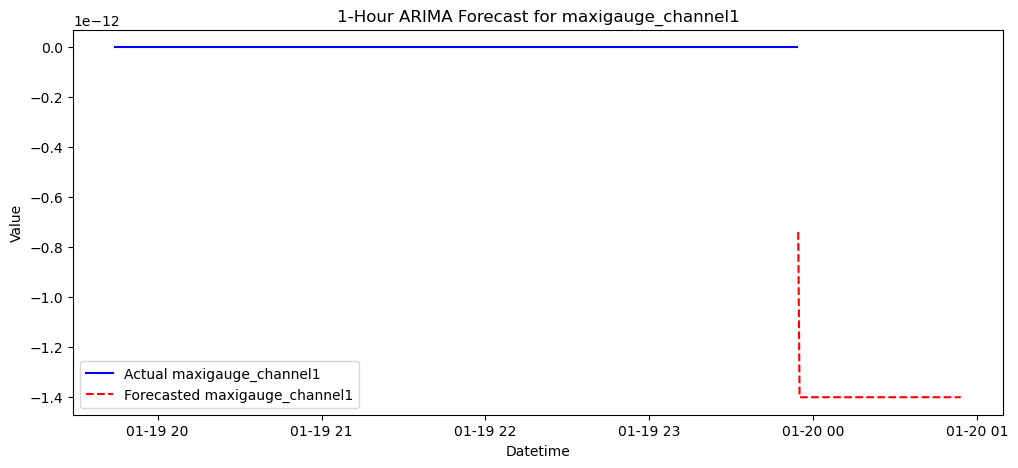

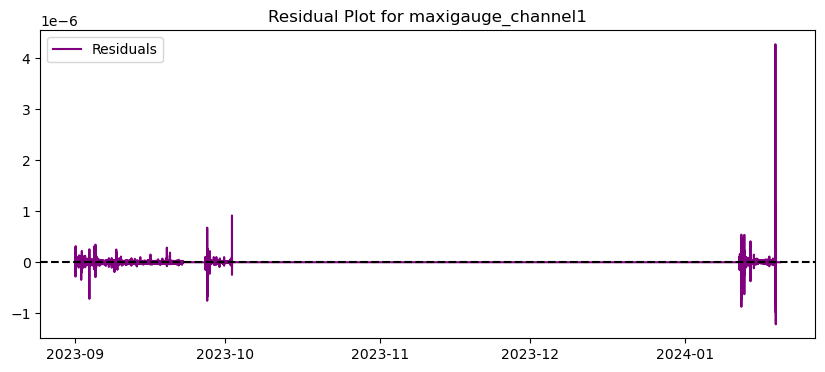


Processing ARIMA for maxigauge_channel2
ADF Statistic: -5.024890820464206, p-value: 1.980880422417247e-05
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2194754.090, Time=32.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2132029.681, Time=4.86 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2173044.966, Time=7.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2192346.707, Time=20.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2115133.882, Time=1.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2193740.163, Time=9.36 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-2193903.915, Time=24.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2195050.753, Time=20.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2195435.624, Time=20.92 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-2193958.158, Time=4.32 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 146.188 seconds
Optimal ARIMA Order for maxigauge_channel2: (0, 1, 2)


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



Evaluation Metrics for maxigauge_channel2:
Mean Absolute Error (MAE): 0.0017
Root Mean Squared Error (RMSE): 0.0018
Kolmogorov-Smirnov Statistic: 0.9286, p-value: 0.0000
Jensen-Shannon Divergence: 0.0094


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


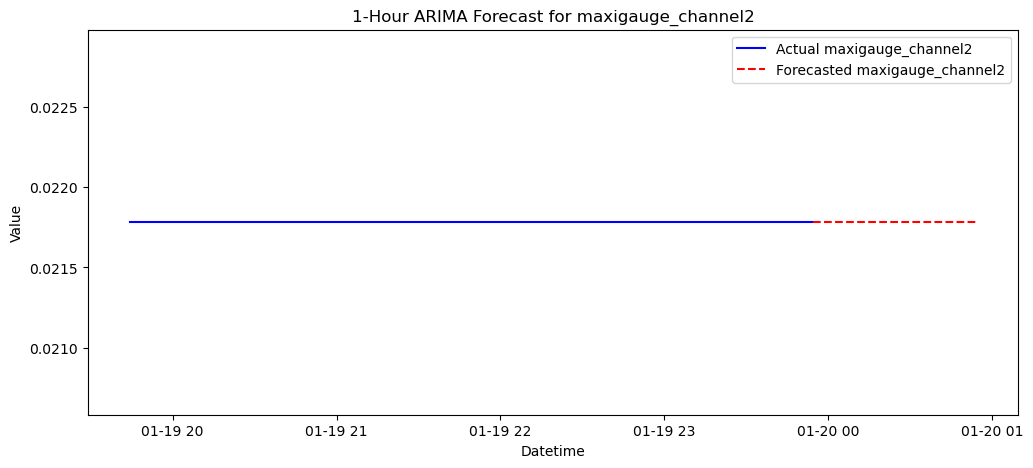

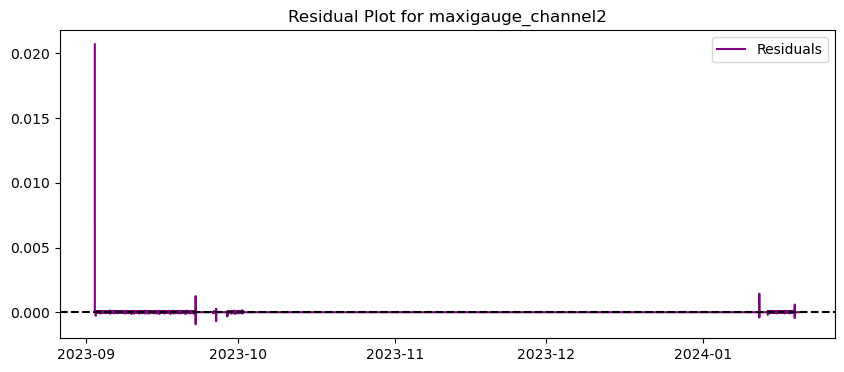


Processing ARIMA for maxigauge_channel6
ADF Statistic: -2.587362486723201, p-value: 0.09563741569660128
Data is NOT stationary, applying first-order differencing...
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-724361.846, Time=7.88 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-596017.133, Time=1.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-709793.999, Time=1.94 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-688287.118, Time=2.68 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-724084.121, Time=3.74 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-719635.515, Time=10.08 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-722992.416, Time=3.60 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-724363.385, Time=21.86 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-724085.279, Time=21.35 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-712746.574, Time=16.49 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-722990.601, Time=12.95 sec

Best model:  ARIMA(2,0,2)(

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r


Evaluation Metrics for maxigauge_channel6:
Mean Absolute Error (MAE): 0.0004
Root Mean Squared Error (RMSE): 0.0012
Kolmogorov-Smirnov Statistic: 0.9445, p-value: 0.0000
Jensen-Shannon Divergence: inf


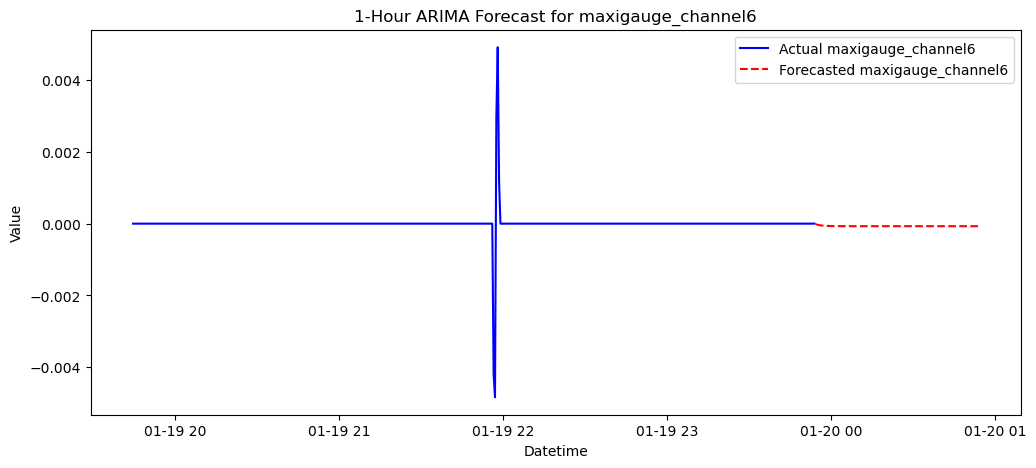

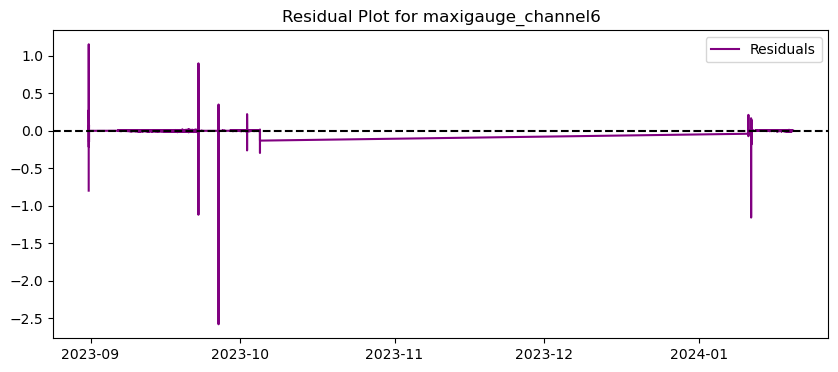

In [42]:
forecast_results = {}

for sensor in selected_channels:
    print(f"\nProcessing ARIMA for {sensor}")
    
    # Step 1: Load and clean data
    data = outliers_df[sensor].dropna()

    # Step 2: Ensure data is stationary
    data = check_stationarity(data)

    # Step 3: Find the optimal ARIMA parameters
    best_order = find_best_arima_params_3(data)
    print(f"Optimal ARIMA Order for {sensor}: {best_order}")
    
    # Step 4: Train the ARIMA model
    model = ARIMA(data, order=best_order)
    model_fit = model.fit()
    
    # Step 5: Forecast next 1 hour (120 steps at 30-second intervals)
    steps_ahead = 120
    forecast = model_fit.forecast(steps=steps_ahead)

    # Generate time index for the forecast
    forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(seconds=30), 
                                   periods=steps_ahead, 
                                   freq='30s')

    # Create DataFrame for forecast results
    forecast_df = pd.DataFrame({'Forecasted Values': forecast.values}, index=forecast_index)
    forecast_results[sensor] = forecast_df

    # Step 6: Evaluate Model Performance
    train_size = int(len(data) * 0.8)
    train, test = data[:train_size], data[train_size:]
    forecast_test = model_fit.forecast(steps=len(test))

    # Compute MAE and RMSE
    mae = mean_absolute_error(test, forecast_test)
    rmse = np.sqrt(mean_squared_error(test, forecast_test))
    
    # KS test
    ks_stat, ks_p_value = ks_2samp(test, forecast_test)

    # Jensen-Shannon divergence (instead of KL)
    js_divergence = jensenshannon(test + 1e-10, forecast_test + 1e-10)

    # Print evaluation metrics
    print(f"\nEvaluation Metrics for {sensor}:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Kolmogorov-Smirnov Statistic: {ks_stat:.4f}, p-value: {ks_p_value:.4f}")
    print(f"Jensen-Shannon Divergence: {js_divergence:.4f}")

    # Step 7: Plot actual vs. forecasted values
    plt.figure(figsize=(12, 5))
    
    # Plot last 500 actual values
    plt.plot(data.index[-500:], data.values[-500:], label=f"Actual {sensor}", color='blue')
    
    # Plot full 1-hour forecast
    plt.plot(forecast_df.index, forecast_df["Forecasted Values"], label=f"Forecasted {sensor}", color='red', linestyle='dashed')
    
    plt.xlabel("Datetime")
    plt.ylabel("Value")
    plt.title(f"1-Hour ARIMA Forecast for {sensor}")
    plt.legend()
    plt.show()

    # Step 8: Plot Residuals
    residuals = model_fit.resid
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label="Residuals", color="purple")
    plt.axhline(y=0, linestyle="--", color="black")
    plt.title(f"Residual Plot for {sensor}")
    plt.legend()
    plt.show()

# Arimax

## Arimax for all datasets and selected sensors channels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import joblib
import logging
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon

#### Step 1: Load dataset

In [4]:
# Replace "sensor_data.csv" with your actual dataset file
arimax_df = pd.read_csv("../databases/processed_data/all.csv")

# Convert 'datetime' column to pandas datetime format and set as index
arimax_df['datetime'] = pd.to_datetime(arimax_df['datetime'])
arimax_df.set_index('datetime', inplace=True)

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

#### Step 2: Improved Outlier Handling

In [5]:
# Improved Outlier Handling
# def cap_outliers(df):
#     for column in df.columns:
#         Q1 = df[column].quantile(0.25)
#         Q3 = df[column].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 1.5 * IQR
#         upper_bound = Q3 + 1.5 * IQR
#         df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
#     return df

# all_data = cap_outliers(arimax_df)

#### Step 3: Check for stationarity

In [6]:
# Check for stationarity and apply differencing if necessary
from pmdarima.arima.utils import ndiffs

def make_stationary(series, max_diff=2):
    # Fill NaNs before testing for differencing
    series = series.ffill().bfill()
    
    # Determine the required number of differences
    d = ndiffs(series, test='adf', max_d=max_diff)
    
    # Apply differencing if needed
    if d > 0:
        return series.diff(d).dropna()
    return series

# Apply to all columns
for column in arimax_df.columns:
    arimax_df[column] = make_stationary(arimax_df[column])

#### Step 4: Split dataset and define Arimax relationships

In [7]:
# Train-test split
def train_test_split(series, split_ratio=0.8):
    split = int(len(series) * split_ratio)
    return series[:split], series[split:]

# Define ARIMAX relationships
target_exog_pairs = {
    'cooling_channel0': ['cooling_channel1', 'cooling_channel10', 'cooling_channel11'],
    'temperature_channel1': ['temperature_channel2', 'temperature_channel5', 'temperature_channel6']
}

#### Step 5: Train and Evaluate Arimax model

In [8]:
# Evaluate model
def evaluate_model(test, forecast):
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = mean_absolute_percentage_error(test, forecast)
    
    logging.info(f"MAE: {mae:.2f}")
    logging.info(f"RMSE: {rmse:.2f}")
    logging.info(f"MAPE: {mape:.2f}%")
    
    # Plot actual vs. forecasted values
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, forecast, label='Forecast', linestyle='--')
    plt.legend()
    plt.show()

In [9]:
# Train ARIMAX models
def fit_arimax_models(data, target, exog):
    models = {}
    target_series = data[target].dropna()
    exog_data = data[exog].dropna()
    target_series, exog_data = target_series.align(exog_data, join='inner')
    
    if len(target_series) == 0 or len(exog_data) == 0:
        logging.warning(f"Skipping {target}: No aligned data")
        return {}
    
    train, test = train_test_split(target_series)
    exog_train, exog_test = train_test_split(exog_data)
    
    model = auto_arima(
        train,
        exogenous=exog_train,
        seasonal=True,
        m=120,  # Adjusted for 1-hour seasonality with 30s interval data
        stepwise=True,
        suppress_warnings=True,
        trace=True,
        start_p=0, max_p=3,
        start_q=0, max_q=3,
        d=None,
        D=None,
        error_action='ignore'
    )
    models[target] = model
    
    forecast, conf_int = model.predict(n_periods=len(test), exogenous=exog_test, return_conf_int=True)
    evaluate_model(test, forecast)
    
    return models

In [ ]:
# Train models
models = {}
for target, exog in target_exog_pairs.items():
    models.update(fit_arimax_models(arimax_df, target, exog))

Performing stepwise search to minimize aic


In [ ]:
# Save models
# joblib.dump(models, 'arimax_all_sensors.pkl')

#### Step 6: Visulize the simulated data

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Simulate future data
def simulate_future_data(models, data, target_exog_pairs, forecast_steps=24):
    simulated_data = pd.DataFrame()
    for target, exog in target_exog_pairs.items():
        exog_future = data[exog][-forecast_steps:].dropna()
        forecast, conf_int = models[target].predict(n_periods=forecast_steps, exogenous=exog_future, return_conf_int=True)
        simulated_data[target] = forecast
        simulated_data[f"{target}_lower"] = conf_int[:, 0]
        simulated_data[f"{target}_upper"] = conf_int[:, 1]
    return simulated_data

# Simulate data
simulated_data = simulate_future_data(models, arimax_df, target_exog_pairs)

In [ ]:
# create subplots
num_targets = len(target_exog_pairs)
fig = make_subplots(rows=num_targets, cols=1, subplot_titles=list(target_exog_pairs.keys()))

# plot simulated data
for i, target in enumerate(target_exog_pairs.keys(), start=1):
    # original data
    fig.add_trace(go.Scatter(
        x=arimax_df.index,
        y=arimax_df[target].dropna(),
        mode='lines',
        name=f'Original {target}',
        line=dict(color='blue')
    ), row=i, col=1)
    
    # simulated data
    fig.add_trace(go.Scatter(
        x=pd.date_range(start=arimax_df.index[-1], periods=24, freq='30s'),
        y=simulated_data[target],
        mode='lines',
        name=f'Simulated {target}',
        line=dict(color='red', dash='dot')
    ), row=i, col=1)
    
    # confidence interval
    fig.add_trace(go.Scatter(
        x=pd.date_range(start=arimax_df.index[-1], periods=24, freq='30s'),
        y=simulated_data[f"{target}_lower"],
        mode='lines',
        name=f'Lower Bound {target}',
        line=dict(color='gray', width=1)
    ), row=i, col=1)
    fig.add_trace(go.Scatter(
        x=pd.date_range(start=arimax_df.index[-1], periods=24, freq='30s'),
        y=simulated_data[f"{target}_upper"],
        mode='lines',
        name=f'Upper Bound {target}',
        line=dict(color='gray', width=1),
        fill='tonexty'  # fill area between traces
    ), row=i, col=1)

# update layout
fig.update_layout(
    title_text="Simulated Sensor Data with ARIMAX",
    showlegend=True,
    height=300 * num_targets,  # adjust height based on number of targets
    width=1000
)

# show plot
fig.show()

In [ ]:
# Export simulated data
# simulated_data.to_csv('../databases/processed_data/simulated_sensor_data_arimax.csv', index=True)
logging.info("Simulation for cooling and temperature sensor channels completed.")

## Multi-stage ARIMAX approach
implement a hierarchical ARIMA approach, where you first model each sensor type independently and then combine them into a final ARIMAX model for an overall sensor simulator.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import joblib
import logging
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import adfuller

In [53]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load all datasets from processed_data directory
def load_data():
    datasets = {}
    dataset_names = ['cd230831', 'cd230926', 'cd240111']
    
    for name in dataset_names:        
        df = pd.read_csv(f"../databases/processed_data/{name}.csv")
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
        datasets[name] = df
        logging.info(f"Loaded {name}.csv with {df.shape[0]} rows.")
    
    return datasets

datasets = load_data()

2025-03-15 17:35:36,617 - INFO - Loaded cd230831.csv with 69112 rows.
2025-03-15 17:35:36,642 - INFO - Loaded cd230926.csv with 25911 rows.
2025-03-15 17:35:36,667 - INFO - Loaded cd240111.csv with 25909 rows.


In [54]:
datasets

{'cd230831':                      cooling_channel0  cooling_channel1  cooling_channel10  \
 datetime                                                                     
 2023-08-31 00:00:30         15.596670         15.558330          15.542780   
 2023-08-31 00:01:00         15.594503         15.558330          15.538204   
 2023-08-31 00:01:30         15.592003         15.558330          15.532924   
 2023-08-31 00:02:00         15.590465         15.553758          15.537758   
 2023-08-31 00:02:30         15.589075         15.548483          15.544148   
 ...                               ...               ...                ...   
 2023-09-23 23:54:00         15.617176         15.581013          15.533379   
 2023-09-23 23:54:30         15.608149         15.574485          15.525739   
 2023-09-23 23:55:00         15.599121         15.567958          15.518099   
 2023-09-23 23:55:30         15.590094         15.561430          15.510459   
 2023-09-23 23:56:00         15.588890  

In [55]:
# Concatenate time series datasets ensuring correct time alignment
all_data = pd.concat([datasets['cd230831'], datasets['cd230926'], datasets['cd240111']], axis=0).sort_index()

# Handle missing values
all_data.interpolate(method='linear', inplace=True)

# Improved Outlier Handling
def cap_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

all_data = cap_outliers(all_data)

In [56]:
all_data

,cooling_channel0,cooling_channel1,cooling_channel10,cooling_channel11,maxigauge_channel1,maxigauge_channel2,maxigauge_channel3,maxigauge_channel4,maxigauge_channel5,maxigauge_channel6,temperature_channel1,temperature_channel2,temperature_channel5,temperature_channel6
datetime,,,,,,,,,,,,,,
2023-08-31 00:00:30,25.544539,15.941692,24.885561,16.212245,0.000019,0.0247,-1.480000,534.890230,710.0,9.244284,76.417893,32.715448,85.867715,0.000297
2023-08-31 00:01:00,25.544539,15.941692,24.885561,16.212245,0.000019,0.0247,-1.474754,534.890230,710.0,9.244284,76.417893,32.715448,85.867715,0.000297
2023-08-31 00:01:30,25.544539,15.941692,24.885561,16.212245,0.000019,0.0247,-1.455082,534.890230,710.0,9.244284,76.417893,32.715448,85.867715,0.000297
2023-08-31 00:02:00,25.544539,15.941692,24.885561,16.212245,0.000019,0.0247,-1.440000,534.890230,710.0,9.244284,76.417893,32.715448,85.867715,0.000297
2023-08-31 00:02:30,25.544539,15.941692,24.885561,16.212245,0.000019,0.0247,-1.440000,534.890230,710.0,9.244284,76.417893,32.715448,85.867715,0.000297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-19 23:52:00,25.544539,15.941692,24.885561,16.212245,0.000019,0.0207,-3.042097,679.000000,723.0,2.760000,76.417893,32.715448,85.867715,0.000297
2024-01-19 23:52:30,25.544539,15.941692,24.885561,16.212245,0.000019,0.0207,-3.034098,678.918033,723.0,2.760000,76.417893,32.715448,85.867715,0.000297
2024-01-19 23:53:00,25.544539,15.941692,24.885561,16.212245,0.000019,0.0207,-3.058689,678.426230,723.0,2.760000,76.417893,32.715448,85.867715,0.000297


In [57]:
# Check for stationarity and apply differencing if necessary
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05

def make_stationary(series):
    return series.diff().dropna()

for column in all_data.columns:
    if not check_stationarity(all_data[column]):
        all_data[column] = make_stationary(all_data[column])
        logging.info(f"Applied differencing to {column} to ensure stationarity.")

2025-03-15 17:38:03,229 - INFO - Applied differencing to maxigauge_channel1 to ensure stationarity.
2025-03-15 17:38:57,379 - INFO - Applied differencing to maxigauge_channel5 to ensure stationarity.
2025-03-15 17:39:25,197 - INFO - Applied differencing to temperature_channel1 to ensure stationarity.
2025-03-15 17:39:40,664 - INFO - Applied differencing to temperature_channel2 to ensure stationarity.
2025-03-15 17:39:56,275 - INFO - Applied differencing to temperature_channel5 to ensure stationarity.


In [58]:
all_data

,cooling_channel0,cooling_channel1,cooling_channel10,cooling_channel11,maxigauge_channel1,maxigauge_channel2,maxigauge_channel3,maxigauge_channel4,maxigauge_channel5,maxigauge_channel6,temperature_channel1,temperature_channel2,temperature_channel5,temperature_channel6
datetime,,,,,,,,,,,,,,
2023-08-31 00:00:30,25.544539,15.941692,24.885561,16.212245,NaN,0.0247,-1.480000,534.890230,NaN,9.244284,NaN,NaN,NaN,0.000297
2023-08-31 00:01:00,25.544539,15.941692,24.885561,16.212245,0.0,0.0247,-1.474754,534.890230,0.0,9.244284,0.0,0.0,0.0,0.000297
2023-08-31 00:01:30,25.544539,15.941692,24.885561,16.212245,0.0,0.0247,-1.455082,534.890230,0.0,9.244284,0.0,0.0,0.0,0.000297
2023-08-31 00:02:00,25.544539,15.941692,24.885561,16.212245,0.0,0.0247,-1.440000,534.890230,0.0,9.244284,0.0,0.0,0.0,0.000297
2023-08-31 00:02:30,25.544539,15.941692,24.885561,16.212245,0.0,0.0247,-1.440000,534.890230,0.0,9.244284,0.0,0.0,0.0,0.000297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-19 23:52:00,25.544539,15.941692,24.885561,16.212245,0.0,0.0207,-3.042097,679.000000,0.0,2.760000,0.0,0.0,0.0,0.000297
2024-01-19 23:52:30,25.544539,15.941692,24.885561,16.212245,0.0,0.0207,-3.034098,678.918033,0.0,2.760000,0.0,0.0,0.0,0.000297
2024-01-19 23:53:00,25.544539,15.941692,24.885561,16.212245,0.0,0.0207,-3.058689,678.426230,0.0,2.760000,0.0,0.0,0.0,0.000297


In [ ]:
# Train-test split
def train_test_split(series, split_ratio=0.8):
    split = int(len(series) * split_ratio)
    return series[:split], series[split:]

# Define sensor categories
temperature_sensors = ['temperature_channel1', 'temperature_channel2', 'temperature_channel5', 'temperature_channel6']
cooling_sensors = ['cooling_channel0', 'cooling_channel1', 'cooling_channel10', 'cooling_channel11']

In [ ]:
# Train ARIMAX models per category
def train_category_models(data, sensor_list):
    models = {}
    for sensor in sensor_list:
        series = data[sensor].dropna()
        if len(series) < 30:
            logging.warning(f"Skipping {sensor}: Not enough data")
            continue
        
        train, test = train_test_split(series)
        model = auto_arima(train, seasonal=True, stepwise=True, suppress_warnings=True, trace=True)
        models[sensor] = model
        forecast = model.predict(n_periods=len(test))
        mae = mean_absolute_error(test, forecast)``
        logging.info(f"Validation MAE for {sensor}: {mae:.2f}")
    return models

In [ ]:
# Train individual ARIMAX models
temperature_models = train_category_models(all_data, temperature_sensors)
cooling_models = train_category_models(all_data, cooling_sensors)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-726804.253, Time=27.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-690759.446, Time=2.27 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-697027.046, Time=2.74 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-716601.063, Time=13.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-690761.446, Time=1.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-723501.004, Time=19.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-723636.144, Time=8.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-725938.637, Time=18.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-725289.078, Time=13.84 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-720084.550, Time=15.72 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-729259.333, Time=31.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-728501.539, Time=8.20 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-729364.757, Time=17.73 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-729538.93

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-15 19:08:03,204 - INFO - Validation MAE for temperature_channel1: 0.00


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=-737761.887, Time=21.42 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0]          
Total fit time: 920.221 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-605752.901, Time=14.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-587061.826, Time=4.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-588268.513, Time=3.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-590037.931, Time=10.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-587063.826, Time=1.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-606294.389, Time=12.19 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-602755.403, Time=27.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-594129.464, Time=17.57 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-605972.135, Time=13.89 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-604926.413, Time=11.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-604331.297, Time=37.41 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-15 19:12:39,475 - INFO - Validation MAE for temperature_channel2: 0.00


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-605951.417, Time=13.06 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0]          
Total fit time: 275.922 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-580245.685, Time=28.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-544925.351, Time=2.41 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-547072.533, Time=3.66 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-554869.392, Time=7.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-544927.351, Time=1.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-577005.519, Time=28.85 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-572920.185, Time=21.87 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-575693.710, Time=6.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-580401.192, Time=39.43 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-578610.568, Time=40.46 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-576241.907, Time=17.90 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-15 19:20:03,257 - INFO - Validation MAE for temperature_channel5: 0.01


 ARIMA(3,1,4)(0,0,0)[0]             : AIC=-577861.445, Time=18.72 sec

Best model:  ARIMA(2,1,3)(0,0,0)[0]          
Total fit time: 443.387 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1411714.137, Time=10.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1411036.958, Time=3.96 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1411662.059, Time=5.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1411633.305, Time=5.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1411038.213, Time=2.60 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1411713.215, Time=9.53 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1411711.650, Time=9.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1411713.967, Time=12.47 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1411714.788, Time=13.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-1411716.381, Time=12.14 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-1411704.403, Time=9.47 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept 

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-15 19:23:57,513 - INFO - Validation MAE for temperature_channel6: 0.01


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=-1411711.803, Time=14.26 sec

Best model:  ARIMA(1,1,3)(0,0,0)[0]          
Total fit time: 233.848 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-481606.759, Time=4.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-417253.388, Time=2.68 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-461004.461, Time=2.91 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-477631.855, Time=6.63 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-417255.388, Time=1.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-481519.871, Time=12.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-481621.942, Time=20.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-481623.345, Time=11.86 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-481444.070, Time=17.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-472895.792, Time=4.41 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-481625.347, Time=3.24 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-4

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-15 19:25:47,192 - INFO - Validation MAE for cooling_channel0: 3.78


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-481608.770, Time=1.56 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0]          
Total fit time: 109.465 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-607924.049, Time=29.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-504243.589, Time=3.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-570291.126, Time=3.42 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-594762.313, Time=12.76 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-504245.589, Time=1.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-607494.613, Time=27.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-607387.428, Time=22.70 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-603458.507, Time=16.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-607155.503, Time=41.15 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-606606.776, Time=13.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-607601.860, Time=35.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-15 19:34:50,392 - INFO - Validation MAE for cooling_channel1: 2.11


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-500783.279, Time=21.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-436212.442, Time=2.97 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-480761.240, Time=3.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-496626.979, Time=6.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-436214.442, Time=1.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-500782.596, Time=22.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-500782.463, Time=19.67 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-500695.390, Time=9.25 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-500755.466, Time=27.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-500782.845, Time=13.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-500776.371, Time=15.31 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-500785.718, Time=23.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-496485.472, Time=5.54 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-500790.550

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-15 19:41:37,101 - INFO - Validation MAE for cooling_channel10: 3.19


 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-500787.199, Time=12.73 sec

Best model:  ARIMA(5,1,1)(0,0,0)[0]          
Total fit time: 406.263 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-621893.607, Time=25.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-517598.591, Time=2.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-586702.235, Time=3.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-607773.938, Time=11.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-517600.591, Time=1.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-621720.838, Time=19.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-621790.034, Time=23.98 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-619361.167, Time=21.96 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-622086.543, Time=36.40 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-622203.815, Time=147.47 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-620412.580, Time=55.60 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AI

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-15 20:45:07,066 - INFO - Validation MAE for cooling_channel11: 2.00


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-621820.899, Time=15.39 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 3809.474 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-2065221.217, Time=33.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-2058294.760, Time=8.58 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2058292.106, Time=11.86 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2163327.017, Time=9.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-2049804.105, Time=1.40 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-2075125.439, Time=22.26 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-2171560.160, Time=13.50 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-2084425.191, Time=2952.50 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=-2169910.966, Time=17.38 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-2049794.132, Time=569.79 sec


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-15 21:45:50,530 - INFO - Validation MAE for maxigauge_channel1: 0.00


 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-2049652.377, Time=3.44 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0] intercept
Total fit time: 3643.249 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1659281.392, Time=968.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1657430.085, Time=3.97 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1659213.971, Time=5.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1659190.927, Time=1049.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1657423.211, Time=1.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1659113.736, Time=8.58 sec


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1657407.163, Time=9.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1659401.614, Time=11.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1659214.947, Time=9.98 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-1659889.753, Time=14.34 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-1659759.907, Time=12.80 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-1659882.577, Time=17.39 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-1659895.643, Time=17.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1659762.269, Time=14.79 sec


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning:

divide by zero encountered in reciprocal

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning:

divide by zero encountered in reciprocal



 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-1657382.377, Time=20.65 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-1659894.265, Time=20.07 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-1659893.706, Time=18.04 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=-1659892.290, Time=2504.83 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=-1659883.557, Time=969.01 sec

Best model:  ARIMA(4,1,3)(0,0,0)[0] intercept
Total fit time: 5677.170 seconds


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-15 23:20:28,301 - INFO - Validation MAE for maxigauge_channel2: 0.00


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=421924.753, Time=939.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=527688.394, Time=0.63 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=439192.057, Time=0.67 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=446295.785, Time=3.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=527686.394, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=422075.828, Time=4.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=421947.995, Time=5.49 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=421945.664, Time=628.76 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=421916.570, Time=39.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=421982.999, Time=844.94 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=421928.517, Time=15.40 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=421898.210, Time=1023.07 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=421950.187, Time=984.45 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=421690.534, Time=7

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-16 03:29:35,542 - INFO - Validation MAE for maxigauge_channel3: 461.86


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=421699.661, Time=23.38 sec

Best model:  ARIMA(5,1,5)(0,0,0)[0]          
Total fit time: 14946.652 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=476197.595, Time=15.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=497431.808, Time=0.58 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=484032.007, Time=0.69 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=480406.595, Time=2.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=497429.808, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=477115.931, Time=1080.69 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=477499.639, Time=1995.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=476156.213, Time=2215.83 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=479772.647, Time=1051.62 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=475596.349, Time=1992.36 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=475789.058, Time=740.47 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-16 10:34:24,898 - INFO - Validation MAE for maxigauge_channel4: 101.85


 ARIMA(4,1,5)(0,0,0)[0]             : AIC=473792.972, Time=27.28 sec

Best model:  ARIMA(5,1,4)(0,0,0)[0]          
Total fit time: 25488.642 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=414443.930, Time=13.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=509053.400, Time=0.57 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=461809.859, Time=0.69 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=422808.485, Time=3.41 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=509051.400, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=416389.386, Time=7.95 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=416378.238, Time=6.32 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=414179.587, Time=1815.00 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=416129.103, Time=10.52 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=414114.784, Time=974.22 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=415975.784, Time=1039.29 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=413975.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-16 12:44:13,196 - INFO - Validation MAE for maxigauge_channel5: 0.70


 ARIMA(4,0,4)(0,0,0)[0]             : AIC=412771.576, Time=19.72 sec

Best model:  ARIMA(5,0,5)(0,0,0)[0]          
Total fit time: 7787.953 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-206573.609, Time=28.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-206183.233, Time=4.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-206376.019, Time=2.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-206366.921, Time=2.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-206185.116, Time=1.12 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-206436.505, Time=22.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-206428.936, Time=20.67 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-206799.642, Time=32.94 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-206695.307, Time=22.88 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-206987.021, Time=3.79 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-206978.012, Time=35.96 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

2025-03-16 12:51:41,595 - INFO - Validation MAE for maxigauge_channel6: 1.15


 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-206984.598, Time=15.59 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 447.879 seconds


In [ ]:
# Save individual models
# joblib.dump(temperature_models, 'temperature_arimax.pkl')
# joblib.dump(cooling_models, 'cooling_arimax.pkl')

In [ ]:
# Simulate future values for each category
def simulate_category(models, forecast_steps=24):
    simulated = {}
    last_index = all_data.index[-1]  # Get last available timestamp
    future_dates = pd.date_range(start=last_index, periods=forecast_steps+1, freq='30s')[1:]

    for sensor, model in models.items():
        simulated[sensor] = model.predict(n_periods=forecast_steps)

    simulated_df = pd.DataFrame(simulated, index=future_dates)  # Assign time index
    return simulated_df

temperature_simulated = simulate_category(temperature_models)
cooling_simulated = simulate_category(cooling_models)

# Merge simulated data for final combined ARIMAX model
final_exog = pd.concat([temperature_simulated, cooling_simulated, maxigauge_simulated], axis=1)
final_exog.index = temperature_simulated.index  # Ensure correct DatetimeIndex

final_target = all_data.mean(axis=1).dropna()
final_target.index = all_data.index  # Ensure correct indexing

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/ts

In [28]:
# Train Final ARIMAX Model
train, test = train_test_split(final_target)
exog_train, exog_test = train_test_split(final_exog)
final_model = auto_arima(train, exogenous=exog_train, seasonal=True, stepwise=True, suppress_warnings=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16441.378, Time=7.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=49677.639, Time=2.55 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21038.222, Time=1.77 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=18078.195, Time=3.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=49675.639, Time=0.81 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=16437.446, Time=9.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=16455.061, Time=5.41 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16437.409, Time=3.71 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16438.428, Time=10.81 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=17320.256, Time=2.16 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16435.409, Time=1.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=18076.195, Time=1.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=21036.222, Time=0.58 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16436.428, Time=2.05 sec
 ARIMA(1,1,2)(0,0,

In [29]:
# Predict Final System Simulation
final_forecast, conf_int = final_model.predict(n_periods=24, exogenous=exog_test, return_conf_int=True)

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [ ]:
# Visualize Final Simulation
fig = go.Figure()
fig.add_trace(go.Scatter(x=pd.date_range(start=all_data.index[-1], periods=24, freq='30s'),
                         y=final_forecast, mode='lines', name='Final Simulated System', line=dict(dash='dot')))
fig.add_trace(go.Scatter(x=pd.date_range(start=all_data.index[-1], periods=24, freq='30s'),
                         y=conf_int[:, 0], mode='lines', name='Lower Bound', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=pd.date_range(start=all_data.index[-1], periods=24, freq='30s'),
                         y=conf_int[:, 1], mode='lines', name='Upper Bound', line=dict(color='gray'), fill='tonexty'))

fig.update_layout(title="Final ARIMAX Simulation of All Sensors", xaxis_title="Time", yaxis_title="System Output")
fig.show()

In [11]:
# Export final simulated data
pd.DataFrame({'Final_Forecast': final_forecast, 'Lower_Bound': conf_int[:, 0], 'Upper_Bound': conf_int[:, 1]}).to_csv('final_simulated_system.csv', index=False)
logging.info("Final ARIMAX simulation completed.")

2025-03-13 16:00:11,496 - INFO - Final ARIMAX simulation completed.


### Improved one

In [ ]:
# !pip install bayesian-optimization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import joblib
import logging
from pathlib import Path
from joblib import Parallel, delayed
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from functools import lru_cache
from bayes_opt import BayesianOptimization
from scipy.stats.mstats import winsorize

In [5]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load all datasets from processed_data directory
def load_data():
    datasets = {}
    dataset_names = ['cd230831', 'cd230926', 'cd240111']
    
    for name in dataset_names:
        df = pd.read_csv(f"../databases/processed_data/{name}.csv")
        df['datetime'] = pd.to_datetime(df['datetime'])
        df.set_index('datetime', inplace=True)
        datasets[name] = df
        logging.info(f"Loaded {name}.csv with {df.shape[0]} rows.")
    
    return datasets

datasets = load_data()

2025-03-15 15:54:26,380 - INFO - Loaded cd230831.csv with 69112 rows.
2025-03-15 15:54:26,408 - INFO - Loaded cd230926.csv with 25911 rows.
2025-03-15 15:54:26,433 - INFO - Loaded cd240111.csv with 25909 rows.


In [8]:
# Concatenate time series datasets ensuring correct time alignment
all_data = pd.concat([datasets['cd230831'], datasets['cd230926'], datasets['cd240111']], axis=0).sort_index()

# Handle missing values
all_data.interpolate(method='linear', inplace=True)

# Improved Outlier Handling
def cap_outliers(df):
    for column in df.columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

all_data = cap_outliers(all_data)

In [9]:
# Handle missing values using KNN Imputer
imputer = KNNImputer(n_neighbors=3)
all_data[:] = imputer.fit_transform(all_data)

# Improved Outlier Handling using Winsorization
def cap_outliers(df):
    for column in df.columns:
        df[column] = winsorize(df[column], limits=[0.01, 0.01])  # 1% Winsorization
    return df

all_data = cap_outliers(all_data)

In [10]:
# Check for stationarity and apply seasonal differencing
def check_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05

def make_stationary(series, seasonal_lags=24):
    return series.diff(seasonal_lags).dropna()

diff_order = {}
for column in all_data.columns:
    d = 0
    while not check_stationarity(all_data[column]):
        all_data[column] = make_stationary(all_data[column])
        d += 1
    diff_order[column] = d

In [63]:
# Train-test split
def train_test_split(series, split_ratio=0.8):
    split = int(len(series) * split_ratio)
    return series[:split], series[split:]

In [ ]:

# Define sensor categories
temperature_sensors = ['temperature_channel1', 'temperature_channel2', 'temperature_channel5', 'temperature_channel6']
cooling_sensors = ['cooling_channel0', 'cooling_channel1', 'cooling_channel10', 'cooling_channel11']
maxigauge_sensors = ['maxigauge_channel1', 'maxigauge_channel2', 'maxigauge_channel3', 'maxigauge_channel4', 'maxigauge_channel5', 'maxigauge_channel6']

In [12]:
# Parallelized ARIMAX Training
def train_arimax(sensor, data):
    series = data[sensor].dropna()
    if len(series) < 30:
        logging.warning(f"Skipping {sensor}: Not enough data")
        return None
    
    train, test = train_test_split(series)
    model = auto_arima(train, seasonal=True, stepwise=True, suppress_warnings=True, trace=True)
    mae = mean_absolute_error(test, model.predict(n_periods=len(test)))
    logging.info(f"Validation MAE for {sensor}: {mae:.2f}")
    return sensor, model

In [13]:
sensor_models = Parallel(n_jobs=-1)(
    delayed(train_arimax)(sensor, all_data) for sensor in all_data.columns
)

sensor_models = {sensor: model for sensor, model in sensor_models if model is not None}
# joblib.dump(sensor_models, 'optimized_arimax_models.pkl')

Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-481606.759, Time=3.46 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=410661.551, Time=3.83 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=481463.017, Time=0.54 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=426736.950, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-417253.388, Time=2.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=418673.293, Time=2.49 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=481461.017, Time=0.30 sec
 ARIMA

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1657407.163, Time=9.81 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-2132096.282, Time=9.77 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-540194.170, Time=3.94 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=477499.639, Time=14.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-481621.942, Time=21.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-514029.343, Time=6.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-435062.860, Time=1.30 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-500782.596, Time=25.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1659401.614, Time=12.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-206436.506, Time=23.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-481623.345, Time=12.12 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-2057296.200, Time=14.37 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-621720.838, Time=18.80 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-549830.942, Time=6.87 sec
 ARIMA(0,0,0)(0,0,0)[0]

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=30.17 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-500755.466, Time=29.26 sec
Performing stepwise search to minimize aic
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=496591.919, Time=1.77 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=500018.255, Time=1.66 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-1659882.577, Time=20.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-602963.429, Time=30.78 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-698007.182, Time=28.67 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=410632.814, Time=14.27 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=475596.349, Time=42.17 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=410631.708, Time=2.60 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=411897.735, Time=1.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-500782.845, Time=14.27 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=410656.054, Time=2.91 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=410659.551, Time=2.33 se

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-206987.021, Time=4.24 sec
Performing stepwise search to minimize aic
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-543319.286, Time=29.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-500776.371, Time=16.95 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=29.73 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=475789.058, Time=22.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-622086.543, Time=41.00 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-551171.170, Time=7.50 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-520282.889, Time=35.90 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1411714.137, Time=11.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1659762.269, Time=16.96 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-378084.475, Time=2.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-605551.897, Time=34.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1411036.958, Time=4.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-490030.998, Ti

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1411633.305, Time=5.62 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-500785.718, Time=24.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1411038.213, Time=3.21 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-605117.648, Time=16.15 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-551584.606, Time=23.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=16.59 sec


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-1657382.377, Time=21.71 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-206978.013, Time=35.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-378086.475, Time=1.34 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-496485.472, Time=6.03 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-696923.548, Time=54.68 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1411713.215, Time=9.57 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=474832.383, Time=34.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1411711.650, Time=8.53 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-622203.815, Time=40.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-605534.142, Time=21.56 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-1659894.265, Time=20.67 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=-2142186.398, Time=30.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=24.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1411713.967, Time=11.94 sec
 ARIMA(3,1,2)(0,0,0)[0] int

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-520994.872, Time=37.84 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-548683.930, Time=43.02 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-621994.231, Time=42.17 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-206891.255, Time=38.67 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=-552949.410, Time=5.99 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-2057286.200, Time=34.07 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-1411707.602, Time=11.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-605790.889, Time=46.39 sec


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1908: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-2049308.243, Time=5.50 sec

Best model:  ARIMA(3,0,1)(0,0,0)[0] intercept
Total fit time: 274.954 seconds
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-606316.196, Time=9.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-617875.555, Time=17.86 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-699173.609, Time=52.60 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=473866.192, Time=28.58 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=-1411711.047, Time=15.83 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-206971.273, Time=20.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-605877.509, Time=8.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-519117.992, Time=27.99 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=-1411717.367, Time=8.01 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-552424.084, Time=26.34 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-605774.801, Time=8.41 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-1411705.815, Time=9.58 sec
 ARIMA(5,1,2)(

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=473716.256, Time=47.19 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-620414.256, Time=9.77 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=-695542.897, Time=20.78 sec
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-553287.036, Time=16.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-520681.141, Time=30.56 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=-500896.414, Time=24.83 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-621724.688, Time=7.38 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=-498657.982, Time=1.77 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=-606532.732, Time=16.49 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-206893.893, Time=17.55 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-703136.214, Time=15.62 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-549273.956, Time=12.45 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-621565.282, Time=10.04 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=-698058.485, Time=2.85 sec
 ARIMA(4,1,2)(0,0,0)[0]  

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-206973.161, Time=6.88 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-699322.013, Time=3.98 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-550062.087, Time=12.82 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=-622052.306, Time=13.82 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-549355.369, Time=3.15 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-606548.027, Time=23.04 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-518564.762, Time=29.28 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=-206984.598, Time=14.11 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 424.790 seconds


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-617877.556, Time=5.21 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=-699370.775, Time=21.93 sec
 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-551942.105, Time=14.18 sec
 ARIMA(5,1,2)(0,0,0)[0]             : AIC=-606561.559, Time=17.38 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=-621709.748, Time=15.42 sec
 ARIMA(5,1,5)(0,0,0)[0] intercept   : AIC=473779.553, Time=55.54 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-552265.564, Time=14.60 sec

Best model:  ARIMA(4,1,2)(0,0,0)[0]          
Total fit time: 449.815 seconds


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-622567.290, Time=9.55 sec
 ARIMA(3,1,4)(0,0,0)[0]             : AIC=-700382.347, Time=18.49 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-602465.811, Time=16.79 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-621792.060, Time=7.37 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=-698368.260, Time=5.75 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=35.81 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-621636.385, Time=7.93 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-620828.233, Time=4.79 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=inf, Time=12.13 sec

Best model:  ARIMA(3,1,2)(0,0,0)[0] intercept
Total fit time: 355.247 seconds


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(2,1,4)(0,0,0)[0]             : AIC=-701597.376, Time=19.73 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-621956.870, Time=10.05 sec
 ARIMA(4,1,5)(0,0,0)[0] intercept   : AIC=473794.983, Time=49.31 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=-603812.231, Time=34.55 sec

Best model:  ARIMA(5,1,2)(0,0,0)[0]          
Total fit time: 491.963 seconds


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(3,1,3)(0,0,0)[0]             : AIC=-621820.899, Time=11.64 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0]          
Total fit time: 492.444 seconds
 ARIMA(4,1,2)(0,0,0)[0]             : AIC=-697115.893, Time=14.74 sec


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(4,1,4)(0,0,0)[0]             : AIC=-697547.736, Time=17.48 sec

Best model:  ARIMA(3,1,3)(0,0,0)[0]          
Total fit time: 509.921 seconds


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


 ARIMA(5,1,4)(0,0,0)[0]             : AIC=473534.474, Time=19.69 sec
 ARIMA(4,1,4)(0,0,0)[0]             : AIC=473714.256, Time=16.20 sec
 ARIMA(5,1,3)(0,0,0)[0]             : AIC=473857.877, Time=13.47 sec
 ARIMA(5,1,5)(0,0,0)[0]             : AIC=473778.368, Time=22.50 sec
 ARIMA(4,1,3)(0,0,0)[0]             : AIC=473864.192, Time=6.83 sec
 ARIMA(4,1,5)(0,0,0)[0]             : AIC=473792.972, Time=20.30 sec

Best model:  ARIMA(5,1,4)(0,0,0)[0]          
Total fit time: 590.789 seconds


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [14]:
# Simulate future values
def simulate_future_data(models, forecast_steps=24):
    simulated = {}
    for sensor, model in models.items():
        simulated[sensor] = model.predict(n_periods=forecast_steps)
    return pd.DataFrame(simulated)

simulated_data = simulate_future_data(sensor_models)

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an 

In [16]:
# Train-test split
def train_test_split(series, split_ratio=0.8):
    split = int(len(series) * split_ratio)
    return series[:split], series[split:]

# Select a column for ARIMA modeling
column = 'temperature_channel6'
series = all_data[column].dropna()

# Split the data into training and testing sets
train, test = train_test_split(series)

# Bayesian Optimization for Hyperparameter Tuning
def arima_cv(p, d, q):
    model = ARIMA(train, order=(int(p), int(d), int(q))).fit()
    forecast = model.forecast(len(test))
    return -mean_absolute_error(test, forecast)  # Negative for maximization

optimizer = BayesianOptimization(
    f=arima_cv,
    pbounds={'p': (0, 5), 'd': (0, 2), 'q': (0, 5)},
    random_state=42,
)
optimizer.maximize(init_points=10, n_iter=20)

|   iter    |  target   |     d     |     p     |     q     |
-------------------------------------------------------------


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 1         | -0.00629  | 0.7491    | 4.754     | 3.66      |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


| 2         | -0.01346  | 1.197     | 0.7801    | 0.78      |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 3         | -0.00629  | 0.1162    | 4.331     | 3.006     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

| 4         | -0.01346  | 1.416     | 0.1029    | 4.85      |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

| 5         | -0.01346  | 1.665     | 1.062     | 0.9091    |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


| 6         | -0.006356 | 0.3668    | 1.521     | 2.624     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 7         | -0.006344 | 0.8639    | 1.456     | 3.059     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_date

| 8         | -0.00639  | 0.279     | 1.461     | 1.832     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


| 9         | -0.006349 | 0.9121    | 3.926     | 0.9984    |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

| 10        | -0.01346  | 1.028     | 2.962     | 0.2323    |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


| 11        | -0.01346  | 1.614     | 4.953     | 2.063     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 12        | -0.006329 | 0.4872    | 2.897     | 2.409     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 13        | -0.006307 | 0.4069    | 3.333     | 3.926     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 14        | -0.006286 | 0.04442   | 4.602     | 4.811     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 15        | -0.01346  | 1.566     | 4.242     | 4.949     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3

| 16        | -0.007281 | 0.06467   | 3.781     | 1.647     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 17        | -0.006299 | 0.01992   | 2.236     | 3.898     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

| 18        | -0.006339 | 0.08693   | 4.852     | 0.2746    |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 19        | -0.01346  | 1.711     | 2.573     | 3.062     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


| 20        | -0.006579 | 0.05993   | 0.245     | 2.747     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 21        | -0.00628  | 0.00485   | 2.885     | 4.999     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 22        | -0.00629  | 0.02298   | 4.95      | 3.717     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 23        | -0.01346  | 1.287     | 4.979     | 0.02572   |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 24        | -0.006344 | 0.05132   | 1.069     | 3.706     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stati

| 25        | -0.006481 | 0.02063   | 4.953     | 1.282     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 26        | -0.006335 | 0.03032   | 1.659     | 4.94      |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

| 27        | -0.01346  | 1.448     | 0.01394   | 2.689     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


| 28        | -0.00629  | 0.05076   | 4.029     | 3.909     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  r

| 29        | -0.006339 | 0.02323   | 2.274     | 1.883     |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimizat

| 30        | -0.006339 | 0.0251    | 4.108     | 0.6865    |


/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [17]:
# Save best-performing models
best_models = {k: v for k, v in sensor_models.items() if mean_absolute_error(test, v.predict(n_periods=len(test))) < 5}
# joblib.dump(best_models, 'best_arimax_models.pkl')

/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/liqi/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an 

In [ ]:
# Visualization with Confidence Intervals
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=pd.date_range(start=all_data.index[-1], periods=24, freq='30s'),
    y=simulated_data.mean(axis=1), mode='lines', name='Final Forecast',
    line=dict(color='blue')
))
fig.add_trace(go.Scatter(
    x=pd.date_range(start=all_data.index[-1], periods=24, freq='30s'),
    y=simulated_data.min(axis=1), mode='lines', name='Lower Bound',
    line=dict(color='gray', dash='dot')
))
fig.add_trace(go.Scatter(
    x=pd.date_range(start=all_data.index[-1], periods=24, freq='30s'),
    y=simulated_data.max(axis=1), mode='lines', name='Upper Bound',
    line=dict(color='gray', dash='dot'), fill='tonexty'
))
fig.update_layout(title="Enhanced ARIMAX Forecast", xaxis_title="Time", yaxis_title="Prediction")
fig.show()

In [ ]:
# Export final simulated data
simulated_data.to_csv('final_simulated_system.csv', index=False)
logging.info("Final ARIMAX simulation completed.")